# TMS Functional Connectivity (FC) Maps - SimNIBS OFC (Fp1)


### This NB look at which functional networks are targeted with OFC-rTMS simulation, derived from the SimNIBS e-field patch with coil centre at Fp1.

### Only 0.9 threshold is shown.

### Here we use subject-specific E-fields and a group averaged FC Matrix

### Importage

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os,sys,glob,numpy as np, pandas as pd

from skimage import measure

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from nilearn.image import index_img

from dipy.core.gradients import gradient_table
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines
from dipy.tracking.stopping_criterion import BinaryStoppingCriterion
from dipy.tracking.distances import approx_polygon_track
from dipy.tracking.utils import length
from dipy.io.dpy import Dpy
from dipy.direction import peaks
from dipy.reconst import shm

# from dipy.align.reslice import reslice
# from dipy.viz import fvtk
# from dipy.viz.colormap import line_colors

# from dipy.tracking.utils import connectivity_matrix

import seaborn as sns

# import simnibs
# from simnibs import mni2subject_coords

import scipy
import stl
from scipy import sparse

import networkx as nx

from numpy import sin,cos,pi,kron

# surfdist_dir = '/external/rprshnas01/kcni/hharita/Code/surfdist'
# assert os.path.isdir(surfdist_dir)
# sys.path.append(surfdist_dir)

# import surfdist as sd
# from surfdist.utils import find_node_match
# from surfdist.analysis import dist_calc,dist_calc_matrix

# from surfdist import viz, load, utils
import matplotlib as mlt
from mpl_toolkits.mplot3d import Axes3D
import itertools

from scipy.ndimage.morphology import binary_dilation

from operator import itemgetter

import statistics

%matplotlib inline

### Setup

In [2]:
# subject specific (100307) T1 weighted white matter surface file for LEFT hemisphere ... low resolution (32k)
# again ... this is similar to loading in a dconn file, only the file names have changed ...
lhw32k_file = '/external/rprshnas01/public_datasets/HCP/HCP_S900/100307/T1w/fsaverage_LR32k/100307.L.white_MSMAll.32k_fs_LR.surf.gii'
lhw32k_img = nib.load(lhw32k_file)
lhw32k_vtx = lhw32k_img.darrays[0].data[:]
lhw32k_tri = lhw32k_img.darrays[1].data[:]

df_lhw32k_vtx = pd.DataFrame(lhw32k_vtx,columns=['x', 'y', 'z'])

# subject specific (100307) T1 weighted white matter surface file for RIGHT hemisphere ... low resolution (32k)
rhw32k_file = '/external/rprshnas01/public_datasets/HCP/HCP_S900/100307/T1w/fsaverage_LR32k/100307.R.white_MSMAll.32k_fs_LR.surf.gii'
rhw32k_img = nib.load(rhw32k_file)
rhw32k_vtx = rhw32k_img.darrays[0].data[:]
rhw32k_tri = rhw32k_img.darrays[1].data[:]

df_rhw32k_vtx = pd.DataFrame(rhw32k_vtx,columns=['x', 'y', 'z'])

# concatenate the lh and rh 32k surfaces
lhwrhw32k_vtx = np.concatenate([lhw32k_vtx, rhw32k_vtx])
df_lhwrhw32k_vtx = pd.DataFrame(lhwrhw32k_vtx, columns=['x', 'y', 'z'])

# concatenate lh and rh surfaces (32k)
lhwrhw32k_tri = np.concatenate([lhw32k_tri, rhw32k_tri + lhw32k_vtx.shape[0]])

In [3]:
# Directory

data_direc = '/nethome/kcni/hharita/Data/HCP_WB_Tutorial_TEST/HCP_WB_Tutorial_1.0'

# Left Hemisphere MID-THICKNESS Surface file
mtleft_file = data_direc + '/Q1-Q6_R440.L.midthickness.32k_fs_LR.surf.gii'

# Left Hemisphere INFLATED Surface file
infleft_file = data_direc + '/Q1-Q6_R440.L.inflated.32k_fs_LR.surf.gii'

# Left Hemisphere VERY INFLATED Surface file 

vinfleft_file = data_direc + '/Q1-Q6_R440.L.very_inflated.32k_fs_LR.surf.gii'

# Left Hemisphere PIAL Surface file
pialleft_file = data_direc + '/Q1-Q6_R440.L.pial.32k_fs_LR.surf.gii'

# Left Hemisphere FLAT Surface file

flatleft_file = data_direc + '/Q1-Q6_R440.L.flat.32k_fs_LR.surf.gii'

# curved surface 

curv_file = data_direc + '/Q1-Q6_R440.All.curvature.32k_fs_LR.dscalar.nii'

# sulcus file

sulc_file = data_direc + '/Q1-Q6_R440.All.sulc.32k_fs_LR.dscalar.nii'

# Left hemisphere SPHERICAL surface file

sphere_file = data_direc + '/Q1-Q6_R440.L.sphere.32k_fs_LR.surf.gii'

# for the cifti-2 converted label file

anotherdir = '/external/rprshnas01/kcni/hharita/Data/HCP_WB_Tutorial_TEST/HCP_WB_Tutorial_1.0'
label_file = anotherdir + '/parcellations_VGD11b.32k_fs_LR_c2.dlabel.nii'

# Left Hemisphere PIAL Surface file
pialright_file = data_direc + '/Q1-Q6_R440.R.pial.32k_fs_LR.surf.gii'

In [4]:
# read in the loaded surfaces ...

# Mid-thickness surface
img_mt = nib.load(mtleft_file) 
mt_vtx = img_mt.darrays[0].data
mt_tri = img_mt.darrays[1].data

# Pial surface
img_pial = nib.load(pialleft_file)
pial_vtx = img_pial.darrays[0].data
pial_tri = img_pial.darrays[1].data

# Inflated surface
img_inf = nib.load(infleft_file)
inf_vtx = img_inf.darrays[0].data
inf_tri = img_inf.darrays[1].data

# Inflated surface
img_vinf = nib.load(vinfleft_file)
vinf_vtx = img_vinf.darrays[0].data
vinf_tri = img_vinf.darrays[1].data

# Flat surface 

img_flat = nib.load(flatleft_file)
flat_vtx = img_flat.darrays[0].data
flat_tri = img_flat.darrays[1].data

# Spherical surface

img_sphere = nib.load(sphere_file)
sphere_vtx = img_sphere.darrays[0].data
sphere_tri = img_sphere.darrays[1].data

In [5]:
# mid-thickness
df_mt_vtx = pd.DataFrame(mt_vtx, columns=['x','y','z'])

# pial
df_pial_vtx = pd.DataFrame(pial_vtx, columns=['x','y','z'])

# inflated 
df_inf_vtx = pd.DataFrame(inf_vtx, columns=['x','y','z'])

# very inflated
df_vinf_vtx = pd.DataFrame(vinf_vtx, columns=['x','y','z'])

# flat 
df_flat_vtx = pd.DataFrame(flat_vtx, columns=['x','y','z'])

# spherical
df_sphere_vtx = pd.DataFrame(sphere_vtx, columns=['x','y','z'])

In [6]:

# Pial surface --> RIGHT hemisphere ...
img_pial_rh = nib.load(pialright_file)
pial_vtx_rh = img_pial_rh.darrays[0].data
pial_tri_rh = img_pial_rh.darrays[1].data

xr,yr,zr = pial_vtx_rh.T
x,y,z = pial_vtx.T

In [7]:
# Load the dconn file like previous NBs
dconn_file = '/nethome/kcni/hharita/Data/HCP_1200/HCP_S1200_1003_rfMRI_MSMAll_groupPCA_d4500ROW_zcorr.dconn.nii'
dconn_img = nib.load(dconn_file)
dconn_dat = dconn_img.get_data()
dconn_hdr = dconn_img.header
dconn_ax0 = dconn_hdr.get_axis(0)
dconn_ax1 = dconn_hdr.get_axis(1)

# Load lable file
lab_file =  '/external/rprshnas01/netdata_kcni/jglab/Data/Balsa/null_WG33/Gordon333_FreesurferSubcortical.32k_fs_LR.dlabel.nii'
lab_img = nib.load(lab_file)
lab_dat = np.squeeze(lab_img.get_data())

# Load Sulcus file
sulc_file = '/external/rprshnas01/netdata_kcni/jglab/Data/Balsa/null_WG33/S900.sulc_MSMAll.32k_fs_LR.dscalar.nii'
sulc_img = nib.load(sulc_file)
sulc_ax1 = sulc_img.header.get_axis(1)
sulc_dat = np.squeeze(sulc_img.get_data())

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [8]:
def convert_simnibs_fsavg_to_cifti_32K(in_file,run_it=False):#,base_dir=False):
    
    hcp_pipelines_dir = '/nethome/kcni/hharita/Code/HCPpipelines'
    surf_dir = hcp_pipelines_dir + '/global/templates/standard_mesh_atlases/resample_fsaverage'
    #in_dat = nib.freesurfer.read_morph_data(in_file)
   
    #in_gii = base_dir + '/' + in_file + '_164k.gii'
    in_gii = in_file + '_164k.gii'
    cmd1 = 'mri_convert %s %s' %(in_file,in_gii)
    
    out_gii = in_gii.replace('_164k.gii', '_cifti32k.gii')
    #cmdstr = 'wb_command -metric-resample test_gii.gii fsaverage_std_sphere.L.164k_fsavg_L.surf.gii fs_LR-deformed_to-fsaverage.L.sphere.32k_fs_LR.surf.gii ADAP_BARY_AREA test_gii_32K.gii -area-metrics fsaverage.L.midthickness_va_avg.164k_fsavg_L.shape.gii fs_LR.L.midthickness_va_avg.32k_fs_LR.shape.gii

    f1 = in_gii
       
    #cmdstr = 'wb_command -metric-resample test_gii.gii
    f2 = surf_dir + '/fsaverage_std_sphere.L.164k_fsavg_L.surf.gii'
    f3 = surf_dir + '/fs_LR-deformed_to-fsaverage.L.sphere.32k_fs_LR.surf.gii'
    f4 = out_gii
    f5 = surf_dir + '/fsaverage.L.midthickness_va_avg.164k_fsavg_L.shape.gii'
    f6 = surf_dir + '/fs_LR.L.midthickness_va_avg.32k_fs_LR.shape.gii'
   
    cmd2str = 'wb_command -metric-resample %s %s %s ADAP_BARY_AREA %s -area-metrics %s %s'

   
    cmd2 = cmd2str %(f1,f2,f3,f4,f5,f6)
   
    if run_it:
        print('\n\nconverting input file to .gii\n')
        print(cmd1)
        
        #! $cmd1
        #os.system(cmd1)
        
        print('\n\nconverting .gii file to cifti 32k space\n')
        print(cmd2)
        #! $cmd2
        #os.system(cmd1)
        #os.system(cmd2)
       
       
    return cmd1,cmd2,out_gii



In [9]:
cbig_dir = '/external/rprshnas01/netdata_kcni/jglab/Code/libraries_of_others/github/CBIG'

# Load in 1000 parcellation variant of Schaefer parcellations label file ...
sch1000lab_file = cbig_dir + '/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/HCP/fslr32k/cifti/Schaefer2018_1000Parcels_17Networks_order.dlabel.nii'
sch1000lab_img = nib.load(sch1000lab_file)
sch1000lab_dat = np.squeeze(sch1000lab_img.get_data())
schaefer_parc = sch1000lab_dat
sch1000lab_ax0 = sch1000lab_img.header.get_axis(0)
sch1000lab_ax1 = sch1000lab_img.header.get_axis(1)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [10]:
# Code courtesy JG ...
# Compute dconn-to-gifti surface mapping ...

lh_idxs,rh_idxs, blah = [],[], []
for a_it in range(0,dconn_ax1.size):
    el = dconn_ax1.get_element(a_it)
    if el[2] == 'CIFTI_STRUCTURE_CORTEX_LEFT':
        lh_idxs.append([a_it,el[1]])
    elif el[2] == 'CIFTI_STRUCTURE_CORTEX_RIGHT':        
        rh_idxs.append([a_it,el[1]])
lh_idxs = np.array(lh_idxs)
rh_idxs = np.array(rh_idxs)

```
the variable "el" is element of dconn_ax1 and looks like this ...

dconn_ax1.get_element(X) ---

('CIFTI_MODEL_TYPE_VOXELS',
 array([38, 55, 46]),
 'CIFTI_STRUCTURE_THALAMUS_RIGHT')


You then check which "el[2]" values have the appropriate tag i.e., CORTEX_LEFT or CORTEX_RIGHT and sort them into lh_idxs or rh_idxs respectively.
```

In [11]:
sub_list = ['151526', '162935', '189349', '191437', '214524', '667056', '680957', '725751', '783462', '872764', '912447', '990366']


In [12]:
simnibs_hcp_dir = '/external/rprshnas01/netdata_kcni/jglab/Data/simnibs/simnibs_hcp'


In [13]:
conn_mat_dir = '/external/rprshnas01/netdata_kcni/jglab/Data/ShreyDIPY_tractography_II/Subj_specific_e_fields_Str_Conn'

In [14]:
tract_dir = '/external/rprshnas01/netdata_kcni/jglab/Data/ShreyDIPY_tractography_II/SimNIBS_Extracted_Streamlines_MkIV'

In [15]:
dat_lh = sch1000lab_dat[0:mt_vtx.shape[0]]

In [16]:
subj_tracts_dir = '/external/rprshnas01/netdata_kcni/jglab/Data/ShreyDIPY_tractography_II/Subj_specific_e_fields_Str_Conn'
subj_e_field_dir = '/external/rprshnas01/netdata_kcni/jglab/Data/SimNIBs_Shrey_fields'

In [17]:
# Schaefer
Vis_Schaefer_Parc = np.arange(1, 67, dtype = float) # Visual Network
SomMot_Schaefer_Parc = np.arange(67, 148, dtype = float)  # Somato-Motor Network
DorsAttn_Schaefer_Parc = np.arange(148, 211, dtype = float)  # Dorsal Attention Network
VentAttn_Schaefer_Parc = np.arange(211, 273, dtype = float)  # Ventral Attention Network
Limbic_Schaefer_Parc = np.arange(273, 303, dtype = float)  # Limbic Network
FPN_Schaefer_Parc = np.arange(303, 378, dtype = float)  # Fronto-Parietal Network
DMN_Schaefer_Parc = np.arange(378, 485, dtype = float) #Tempero-Parietal Network
TempPar_Schaefer_Parc = np.arange(485,501, dtype = float) # Defualt Mode Network

# ---------------------------------------------------------------------------------------------------------------

### Define Functional Networks

In [18]:
%%time
# Stitch patches together ...

# Visual 

# empty list
vis_alist = [] 

# Nested loop to go through each of the sub-regions of the target network (eg: DMN)
for index, value in enumerate(Vis_Schaefer_Parc):

    vis_net_num = value # number code for target network (eg: 15, 16 or 17 for DMN)

    # Isolate the target network's sub regions 
    # The "schaefer_parc" variable has regions with tags from 1. to 17.; you want only 15., 16., 17. in the case of DMN
    vis_thisnet_idxs = np.nonzero(schaefer_parc==vis_net_num)[0]

    # Put the identified subregions in a list
    vis_thing = list(vis_thisnet_idxs)

    # grow the list for each identified sub-region.
    vis_alist+=vis_thing 

# Out of the inner loop --
# Now you're gonna look the functional connectivity between vertex 'X' and the sub-regions of interest.

# Make an array out of all the sub-regions of interest 
vis_net_idxs = np.array(vis_alist)

# Use the lh_idxs look up table to get correct indices for func conn network vtxs
dconn_vis_net_idxs = []
for m in vis_net_idxs:
    this_idx = np.nonzero(m==lh_idxs[:,1])[0]
    if this_idx.shape[0] > 0:
        dconn_vis_net_idxs.append(this_idx[0])
dconn_vis_net_idxs = np.array(dconn_vis_net_idxs)

# =======================================================================================================================================

# Somato-Motor

# empty list
sommot_alist = [] 

# Nested loop to go through each of the sub-regions of the target network (eg: DMN)
for index, value in enumerate(SomMot_Schaefer_Parc):

    sommot_net_num = value # number code for target network (eg: 15, 16 or 17 for DMN)

    # Isolate the target network's sub regions 
    # The "schaefer_parc" variable has regions with tags from 1. to 17.; you want only 15., 16., 17. in the case of DMN
    sommot_thisnet_idxs = np.nonzero(schaefer_parc==sommot_net_num)[0]

    # Put the identified subregions in a list
    sommot_thing = list(sommot_thisnet_idxs)

    # grow the list for each identified sub-region.
    sommot_alist+=sommot_thing 

# Out of the inner loop --
# Now you're gonna look the functional connectivity between vertex 'X' and the sub-regions of interest.

# Make an array out of all the sub-regions of interest 
sommot_net_idxs = np.array(sommot_alist)

dconn_sommot_net_idxs = []
for m in sommot_net_idxs:
    this_idx = np.nonzero(m==lh_idxs[:,1])[0]
    if this_idx.shape[0] > 0:
        dconn_sommot_net_idxs.append(this_idx[0])
dconn_sommot_net_idxs = np.array(dconn_sommot_net_idxs)
        
# =======================================================================================================================================

# Dorsal Attention

# empty list
dorsattn_alist = [] 

# Nested loop to go through each of the sub-regions of the target network (eg: DMN)
for index, value in enumerate(DorsAttn_Schaefer_Parc):

    dorsattn_net_num = value # number code for target network (eg: 15, 16 or 17 for DMN)

    # Isolate the target network's sub regions 
    # The "schaefer_parc" variable has regions with tags from 1. to 17.; you want only 15., 16., 17. in the case of DMN
    dorsattn_thisnet_idxs = np.nonzero(schaefer_parc==dorsattn_net_num)[0]

    # Put the identified subregions in a list
    dorsattn_thing = list(dorsattn_thisnet_idxs)

    # grow the list for each identified sub-region.
    dorsattn_alist+=dorsattn_thing 

# Out of the inner loop --
# Now you're gonna look the functional connectivity between vertex 'X' and the sub-regions of interest.

# Make an array out of all the sub-regions of interest 
dorsattn_net_idxs = np.array(dorsattn_alist)

dconn_dorsattn_net_idxs = []
for m in dorsattn_net_idxs:
    this_idx = np.nonzero(m==lh_idxs[:,1])[0]
    if this_idx.shape[0] > 0:
        dconn_dorsattn_net_idxs.append(this_idx[0])
dconn_dorsattn_net_idxs = np.array(dconn_dorsattn_net_idxs)

# =======================================================================================================================================

# Ventral Attention

# empty list
ventattn_alist = [] 

# Nested loop to go through each of the sub-regions of the target network (eg: DMN)
for index, value in enumerate(VentAttn_Schaefer_Parc):

    ventattn_net_num = value # number code for target network (eg: 15, 16 or 17 for DMN)

    # Isolate the target network's sub regions 
    # The "schaefer_parc" variable has regions with tags from 1. to 17.; you want only 15., 16., 17. in the case of DMN
    ventattn_thisnet_idxs = np.nonzero(schaefer_parc==ventattn_net_num)[0]

    # Put the identified subregions in a list
    ventattn_thing = list(ventattn_thisnet_idxs)

    # grow the list for each identified sub-region.
    ventattn_alist+=ventattn_thing 

# Out of the inner loop --
# Now you're gonna look the functional connectivity between vertex 'X' and the sub-regions of interest.

# Make an array out of all the sub-regions of interest 
ventattn_net_idxs = np.array(ventattn_alist)

dconn_ventattn_net_idxs = []
for m in ventattn_net_idxs:
    this_idx = np.nonzero(m==lh_idxs[:,1])[0]
    if this_idx.shape[0] > 0:
        dconn_ventattn_net_idxs.append(this_idx[0])
dconn_ventattn_net_idxs = np.array(dconn_ventattn_net_idxs)

# =======================================================================================================================================

# Limbic

# empty list
limbic_alist = [] 

# Nested loop to go through each of the sub-regions of the target network (eg: DMN)
for index, value in enumerate(Limbic_Schaefer_Parc):


    limbic_net_num = value # number code for target network (eg: 15, 16 or 17 for DMN)

    # Isolate the target network's sub regions 
    # The "schaefer_parc" variable has regions with tags from 1. to 17.; you want only 15., 16., 17. in the case of DMN
    limbic_thisnet_idxs = np.nonzero(schaefer_parc==limbic_net_num)[0]

    # Put the identified subregions in a list
    limbic_thing = list(limbic_thisnet_idxs)

    # grow the list for each identified sub-region.
    limbic_alist+=limbic_thing 

# Out of the inner loop --
# Now you're gonna look the functional connectivity between vertex 'X' and the sub-regions of interest.

# Make an array out of all the sub-regions of interest 
limbic_net_idxs = np.array(limbic_alist)

dconn_limbic_net_idxs = []
for m in limbic_net_idxs:
    this_idx = np.nonzero(m==lh_idxs[:,1])[0]
    if this_idx.shape[0] > 0:
        dconn_limbic_net_idxs.append(this_idx[0])
dconn_limbic_net_idxs = np.array(dconn_limbic_net_idxs)

# =======================================================================================================================================

# Fronto-Parietal / Control

# empty list
fpn_alist = [] 

# Nested loop to go through each of the sub-regions of the target network (eg: DMN)
for index, value in enumerate(FPN_Schaefer_Parc):

    fpn_net_num = value # number code for target network (eg: 15, 16 or 17 for DMN)

    # Isolate the target network's sub regions 
    # The "schaefer_parc" variable has regions with tags from 1. to 17.; you want only 15., 16., 17. in the case of DMN
    fpn_thisnet_idxs = np.nonzero(schaefer_parc==fpn_net_num)[0]

    # Put the identified subregions in a list
    fpn_thing = list(fpn_thisnet_idxs)

    # grow the list for each identified sub-region.
    fpn_alist+=fpn_thing 

# Out of the inner loop --
# Now you're gonna look the functional connectivity between vertex 'X' and the sub-regions of interest.

# Make an array out of all the sub-regions of interest 
fpn_net_idxs = np.array(fpn_alist)

dconn_fpn_net_idxs = []
for m in fpn_net_idxs:
    this_idx = np.nonzero(m==lh_idxs[:,1])[0]
    if this_idx.shape[0] > 0:
        dconn_fpn_net_idxs.append(this_idx[0])
dconn_fpn_net_idxs = np.array(dconn_fpn_net_idxs)
# =======================================================================================================================================

# Temporo-Parietal 

# empty list
temppar_alist = [] 

# Nested loop to go through each of the sub-regions of the target network (eg: DMN)
for index, value in enumerate(TempPar_Schaefer_Parc):

    temppar_net_num = value # number code for target network (eg: 15, 16 or 17 for DMN)

    # Isolate the target network's sub regions 
    # The "schaefer_parc" variable has regions with tags from 1. to 17.; you want only 15., 16., 17. in the case of DMN
    temppar_thisnet_idxs = np.nonzero(schaefer_parc==temppar_net_num)[0]

    # Put the identified subregions in a list
    temppar_thing = list(temppar_thisnet_idxs)

    # grow the list for each identified sub-region.
    temppar_alist+=temppar_thing 

# Out of the inner loop --
# Now you're gonna look the functional connectivity between vertex 'X' and the sub-regions of interest.

# Make an array out of all the sub-regions of interest 
temppar_net_idxs = np.array(temppar_alist)

dconn_temppar_net_idxs = []
for m in temppar_net_idxs:
    this_idx = np.nonzero(m==lh_idxs[:,1])[0]
    if this_idx.shape[0] > 0:
        dconn_temppar_net_idxs.append(this_idx[0])
dconn_temppar_net_idxs = np.array(dconn_temppar_net_idxs)

# =======================================================================================================================================

# Default Mode

# empty list
dmn_alist = [] 

# Nested loop to go through each of the sub-regions of the target network (eg: DMN)
for index, value in enumerate(DMN_Schaefer_Parc):


    dmn_net_num = value # number code for target network (eg: 15, 16 or 17 for DMN)

    # Isolate the target network's sub regions 
    # The "schaefer_parc" variable has regions with tags from 1. to 17.; you want only 15., 16., 17. in the case of DMN
    dmn_thisnet_idxs = np.nonzero(schaefer_parc==dmn_net_num)[0]

    # Put the identified subregions in a list
    dmn_thing = list(dmn_thisnet_idxs)

    # grow the list for each identified sub-region.
    dmn_alist+=dmn_thing 

# Out of the inner loop --
# Now you're gonna look the functional connectivity between vertex 'X' and the sub-regions of interest.

# Make an array out of all the sub-regions of interest 
dmn_net_idxs = np.array(dmn_alist)

dconn_dmn_net_idxs = []
for m in dmn_net_idxs:
    this_idx = np.nonzero(m==lh_idxs[:,1])[0]
    if this_idx.shape[0] > 0:
        dconn_dmn_net_idxs.append(this_idx[0])
dconn_dmn_net_idxs = np.array(dconn_dmn_net_idxs)

# =======================================================================================================================================
# ------------------------------------------------------------------------------------------------------------------------------------------

CPU times: user 1.82 s, sys: 0 ns, total: 1.82 s
Wall time: 1.82 s


In [ ]:
# See this script for how we derived the E-fields --> SimNIBS_OFC_Subj_specific_e_fields_for_TMS_FC.py

### Load the E-fields

In [19]:
subj_e_field_dir = '/external/rprshnas01/netdata_kcni/jglab/Data/SimNIBs_Shrey_fields_II'

In [20]:
%%time
subj_gii_dat = []  #np.zeros(len(sub_list))
for i in range(len(sub_list)):
    sub = sub_list[i]
    in_file = subj_e_field_dir + '/%s_SimNIBS_e_fields_Fp1_OFC/fsavg_overlays/lh.%s_TMS_1-0001_Magstim_70mm_Fig8_nii_scalar.fsavg.E.norm' % (sub,sub)
    res0,res1,outfile = convert_simnibs_fsavg_to_cifti_32K(in_file,run_it=True) #False)#,base_dir=base_dir)
    gii_img = nib.load(outfile)
    gii_dat = gii_img.darrays[0].data[:]
    subj_gii_dat.append(gii_dat)



converting input file to .gii

mri_convert /external/rprshnas01/netdata_kcni/jglab/Data/SimNIBs_Shrey_fields_II/151526_SimNIBS_e_fields_Fp1_OFC/fsavg_overlays/lh.151526_TMS_1-0001_Magstim_70mm_Fig8_nii_scalar.fsavg.E.norm /external/rprshnas01/netdata_kcni/jglab/Data/SimNIBs_Shrey_fields_II/151526_SimNIBS_e_fields_Fp1_OFC/fsavg_overlays/lh.151526_TMS_1-0001_Magstim_70mm_Fig8_nii_scalar.fsavg.E.norm_164k.gii


converting .gii file to cifti 32k space

wb_command -metric-resample /external/rprshnas01/netdata_kcni/jglab/Data/SimNIBs_Shrey_fields_II/151526_SimNIBS_e_fields_Fp1_OFC/fsavg_overlays/lh.151526_TMS_1-0001_Magstim_70mm_Fig8_nii_scalar.fsavg.E.norm_164k.gii /nethome/kcni/hharita/Code/HCPpipelines/global/templates/standard_mesh_atlases/resample_fsaverage/fsaverage_std_sphere.L.164k_fsavg_L.surf.gii /nethome/kcni/hharita/Code/HCPpipelines/global/templates/standard_mesh_atlases/resample_fsaverage/fs_LR-deformed_to-fsaverage.L.sphere.32k_fs_LR.surf.gii ADAP_BARY_AREA /external/rprshna



converting input file to .gii

mri_convert /external/rprshnas01/netdata_kcni/jglab/Data/SimNIBs_Shrey_fields_II/680957_SimNIBS_e_fields_Fp1_OFC/fsavg_overlays/lh.680957_TMS_1-0001_Magstim_70mm_Fig8_nii_scalar.fsavg.E.norm /external/rprshnas01/netdata_kcni/jglab/Data/SimNIBs_Shrey_fields_II/680957_SimNIBS_e_fields_Fp1_OFC/fsavg_overlays/lh.680957_TMS_1-0001_Magstim_70mm_Fig8_nii_scalar.fsavg.E.norm_164k.gii


converting .gii file to cifti 32k space

wb_command -metric-resample /external/rprshnas01/netdata_kcni/jglab/Data/SimNIBs_Shrey_fields_II/680957_SimNIBS_e_fields_Fp1_OFC/fsavg_overlays/lh.680957_TMS_1-0001_Magstim_70mm_Fig8_nii_scalar.fsavg.E.norm_164k.gii /nethome/kcni/hharita/Code/HCPpipelines/global/templates/standard_mesh_atlases/resample_fsaverage/fsaverage_std_sphere.L.164k_fsavg_L.surf.gii /nethome/kcni/hharita/Code/HCPpipelines/global/templates/standard_mesh_atlases/resample_fsaverage/fs_LR-deformed_to-fsaverage.L.sphere.32k_fs_LR.surf.gii ADAP_BARY_AREA /external/rprshna

In [21]:
gii_all_subs_patches = []
for i in range(len(sub_list)):
    gii_dat = subj_gii_dat[i]
    gii_dat_thr9_bin = (gii_dat>=0.9).astype(float)
    # only above 0.9
    gii_patch_val = 1.
    gii_patch_idx_9 = np.nonzero(gii_dat_thr9_bin==gii_patch_val)[0]
    gii_all_subs_patches.insert(i,gii_patch_idx_9)

In [1]:
# Visualize the E-fields

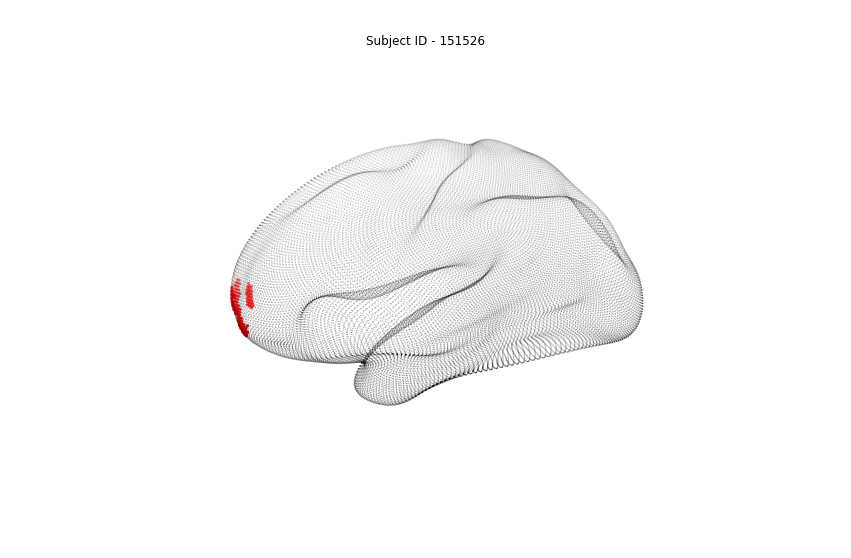

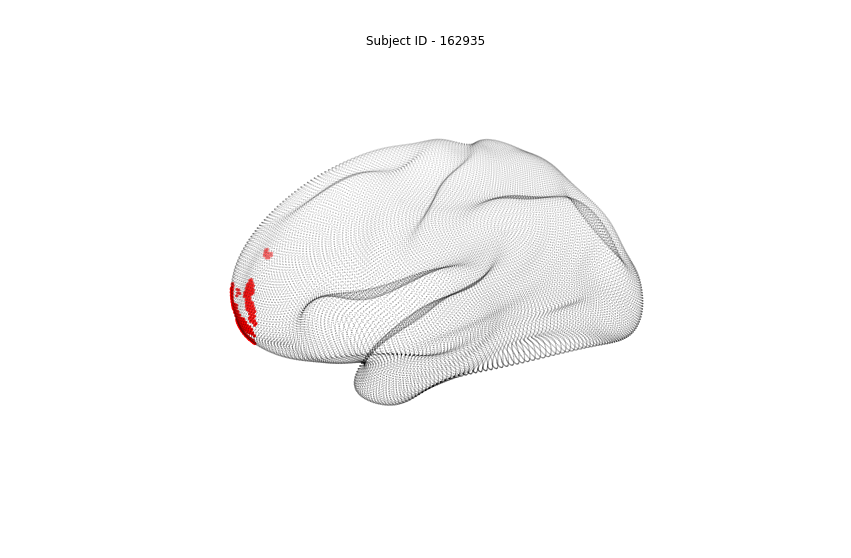

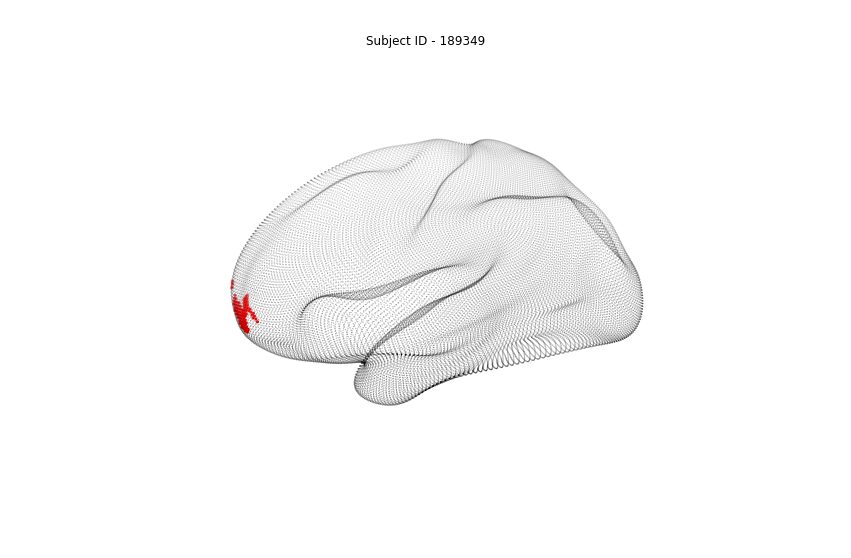

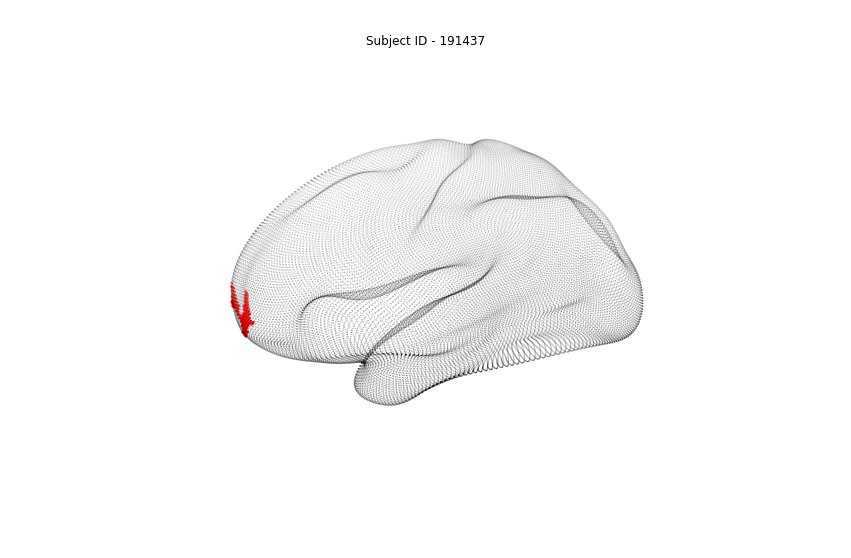

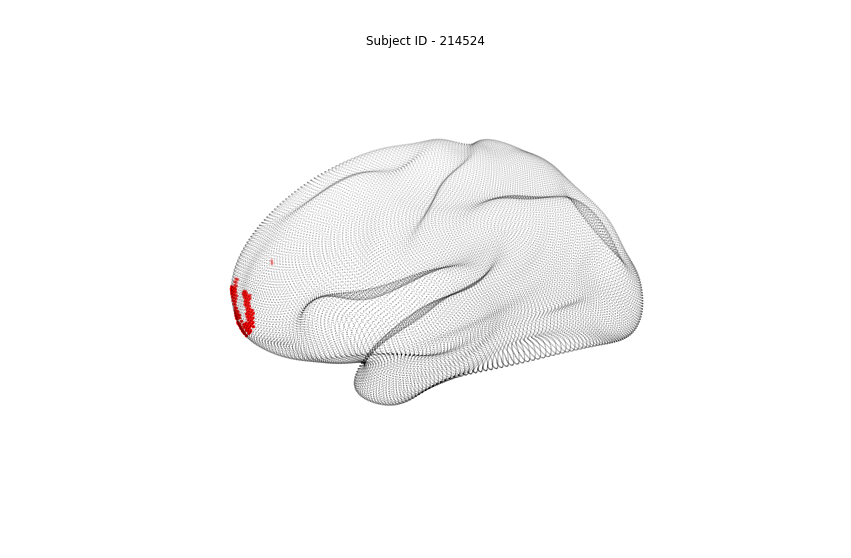

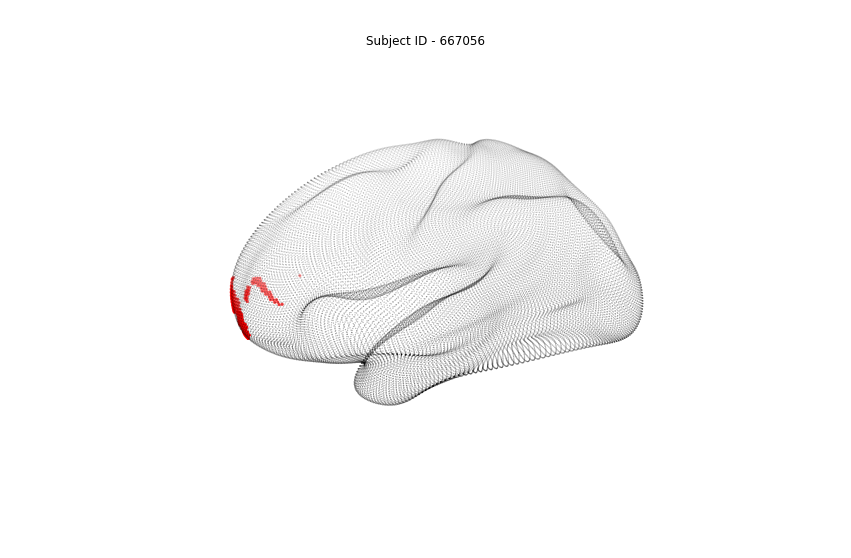

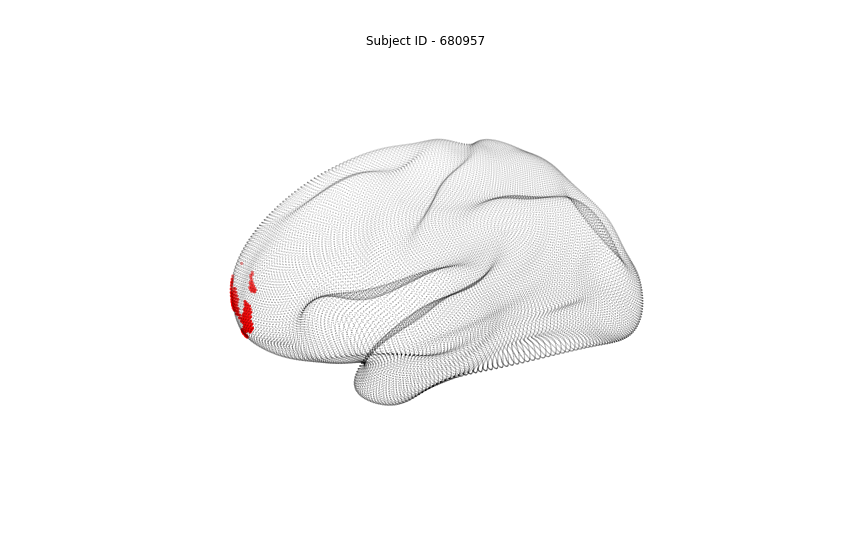

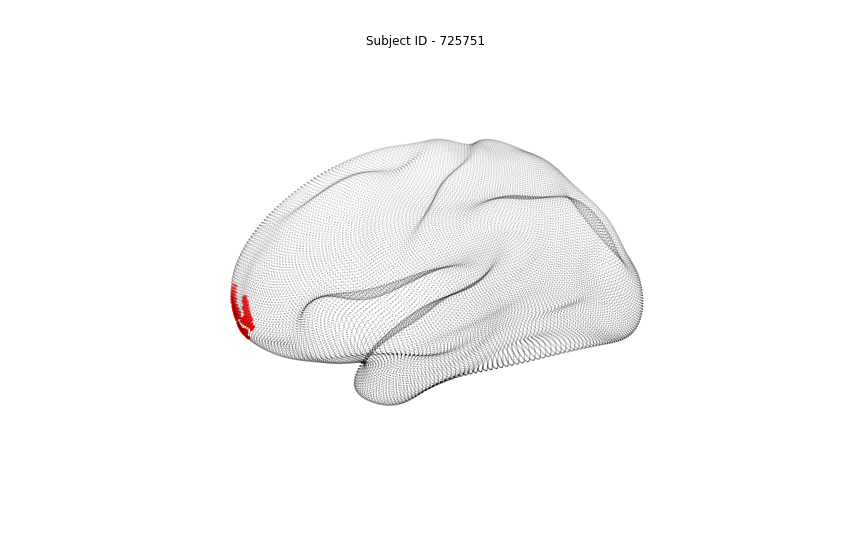

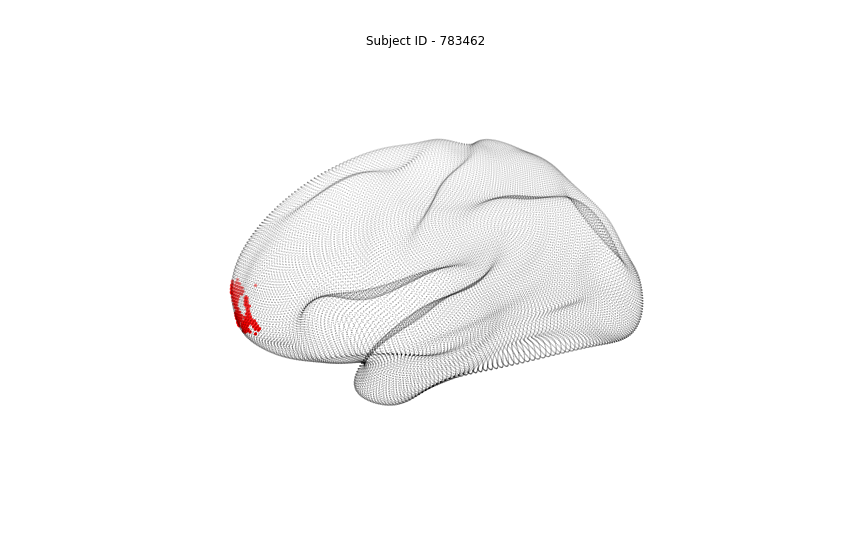

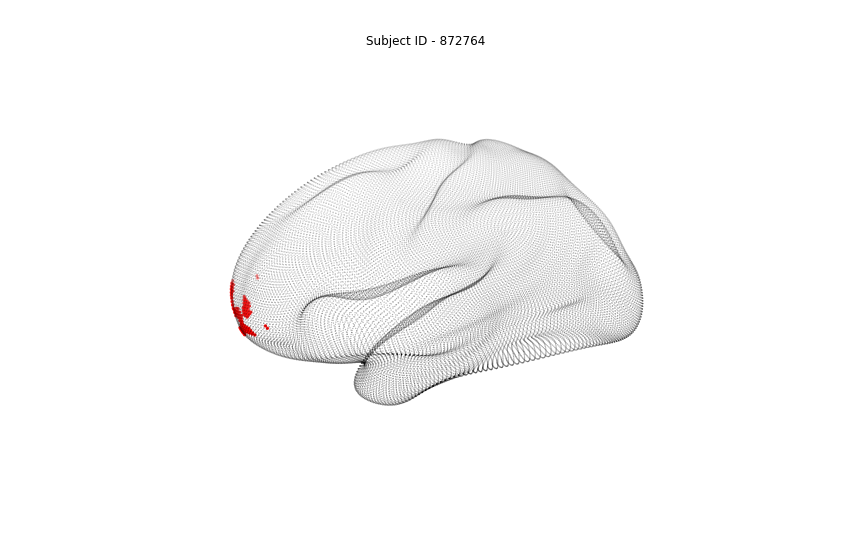

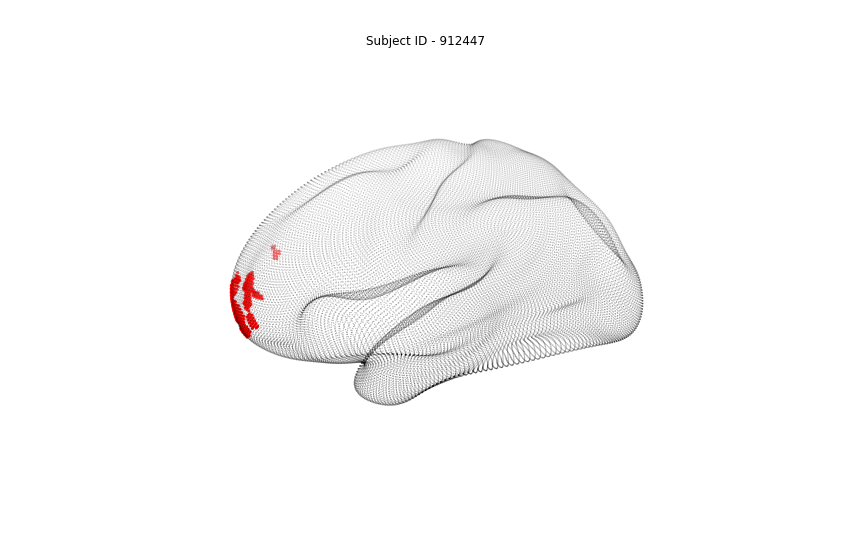

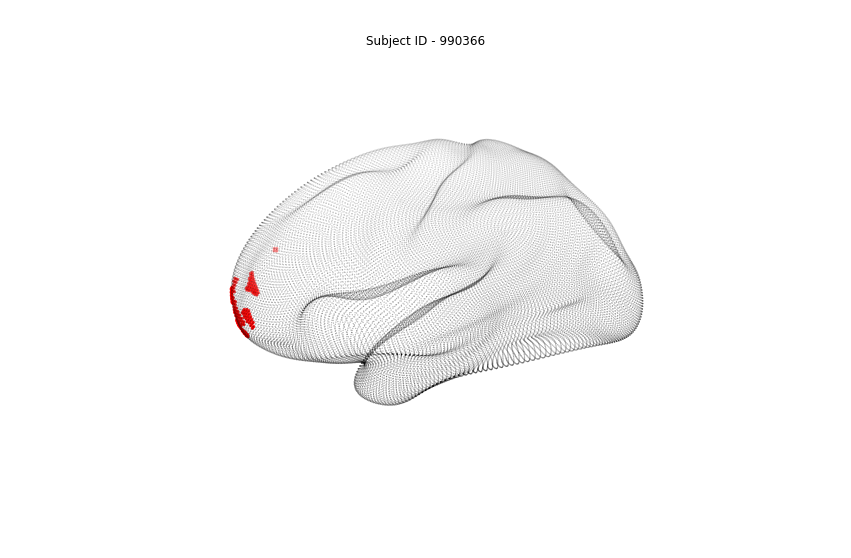

In [22]:
for i in range(12):
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'},figsize=(15,10))
    df_inf_vtx.plot(kind='scatter', x='y', y='z', ax=ax,s=0.1,marker='.',c='k')
    df_inf_vtx.iloc[gii_all_subs_patches[i],:].plot(kind='scatter', x='y', y='z', ax=ax, s=20,marker='.',c='r')
    ax.axis('off')
    ax.view_init(azim=90,elev=-95)
    plt.title('Subject ID - %s' % (sub_list[i]))
    plt.show()

### Run the TMS E-Field FC Analysis

In [23]:
%%time

with_look_up_hcp_ofc_all_networks_df = {}

for i in range(len(sub_list)):
    
    sm_patch_vtx_2 = gii_all_subs_patches[i]

    # Visual Network Shaefer Parc calculations

    vis_vtx_to_net_fc_all,vis_vtx_to_net_fc_mean_all = {},{}

    # Start loop ... go through each vertex in the patch/grid
    for vis_vtx_ind, vis_vtx_val in enumerate(sm_patch_vtx_2):
        
        vis_vtxnum_idx = np.nonzero(lh_idxs==vis_vtx_val)[0]
        vis_vtxnum_idx = vis_vtxnum_idx[0]
        # Average Functional Connectivity from vtx to target network (eg: DMN)
        # get the dconn dat (func conn) of all subregions to the vtx.
        vis_vtx_to_net_fc = dconn_dat[dconn_vis_net_idxs,vis_vtxnum_idx]

        # Add the vtx func conn values to the sub regions to a dictionary i.e., vtx_to_net_fc_mean
        vis_vtx_to_net_fc_all[vis_vtx_ind] = vis_vtx_to_net_fc 

        # get the mean connectivity of all the sub regions to the vtx
        vis_vtx_to_net_fc_mean = np.mean(vis_vtx_to_net_fc)

        # Add the mean to a dictionary i.e., vtx_to_net_fc_mean_all
        vis_vtx_to_net_fc_mean_all[vis_vtx_ind] = vis_vtx_to_net_fc_mean

    with_look_up_vis_patch_mean_df = pd.DataFrame(vis_vtx_to_net_fc_mean_all.values(),index=vis_vtx_to_net_fc_mean_all.keys())
    with_look_up_vis_patch_mean_df.columns = ['Visual: Mean_Func_Conn_Value']    

    # Somato-Motor Schaefer Parc Calculations ...

    # intialize two dictionaries ...
    # one is the net func conn of each vertex to the target network (eg: DMN, Limbic, etc)
    # the other is the mean net func conn of each vertex to the target network (eg: DMN, Limbic, etc)
    sommot_vtx_to_net_fc_all,sommot_vtx_to_net_fc_mean_all = {},{}

    # Start loop ... go through each vertex in the patch/grid
    for sommot_vtx_ind, sommot_vtx_val in enumerate(sm_patch_vtx_2):
        
        sommot_vtxnum_idx = np.nonzero(lh_idxs==sommot_vtx_val)[0]
        sommot_vtxnum_idx = sommot_vtxnum_idx[0]
        # Average Functional Connectivity from vtx to target network (eg: DMN)

        # get the dconn dat (func conn) of all subregions to the vtx.
        sommot_vtx_to_net_fc = dconn_dat[dconn_sommot_net_idxs,sommot_vtxnum_idx]

        # Add the vtx func conn values to the sub regions to a dictionary i.e., vtx_to_net_fc_mean
        sommot_vtx_to_net_fc_all[sommot_vtx_ind] = sommot_vtx_to_net_fc 

        # get the mean connectivity of all the sub regions to the vtx
        sommot_vtx_to_net_fc_mean = np.mean(sommot_vtx_to_net_fc)

        # Add the mean to a dictionary i.e., vtx_to_net_fc_mean_all
        sommot_vtx_to_net_fc_mean_all[sommot_vtx_ind] = sommot_vtx_to_net_fc_mean

    with_look_up_sommot_patch_mean_df = pd.DataFrame(sommot_vtx_to_net_fc_mean_all.values(),index=sommot_vtx_to_net_fc_mean_all.keys())
    with_look_up_sommot_patch_mean_df.columns = ['SomMot: Mean_Func_Conn_Value']

    # ======================================================================================================================

    # Dorsal Attention Network Schaefer Parc Calculations ...

    # intialize two dictionaries ...
    # one is the net func conn of each vertex to the target network (eg: DMN, Limbic, etc)
    # the other is the mean net func conn of each vertex to the target network (eg: DMN, Limbic, etc)
    dorsattn_vtx_to_net_fc_all,dorsattn_vtx_to_net_fc_mean_all = {},{}

    # Start loop ... go through each vertex in the patch/grid
    for dorsattn_vtx_ind, dorsattn_vtx_val in enumerate(sm_patch_vtx_2):
        
        dorsattn_vtxnum_idx = np.nonzero(lh_idxs==dorsattn_vtx_val)[0]
        dorsattn_vtxnum_idx = dorsattn_vtxnum_idx[0]
        # Average Functional Connectivity from vtx to target network (eg: DMN)

        # get the dconn dat (func conn) of all subregions to the vtx.
        dorsattn_vtx_to_net_fc = dconn_dat[dconn_dorsattn_net_idxs,dorsattn_vtxnum_idx]

        # Add the vtx func conn values to the sub regions to a dictionary i.e., vtx_to_net_fc_mean
        dorsattn_vtx_to_net_fc_all[dorsattn_vtx_ind] = dorsattn_vtx_to_net_fc 

        # get the mean connectivity of all the sub regions to the vtx
        dorsattn_vtx_to_net_fc_mean = np.mean(dorsattn_vtx_to_net_fc)

        # Add the mean to a dictionary i.e., vtx_to_net_fc_mean_all
        dorsattn_vtx_to_net_fc_mean_all[dorsattn_vtx_ind] = dorsattn_vtx_to_net_fc_mean

    with_look_up_dorsattn_patch_mean_df = pd.DataFrame(dorsattn_vtx_to_net_fc_mean_all.values(),index=dorsattn_vtx_to_net_fc_mean_all.keys())
    with_look_up_dorsattn_patch_mean_df.columns = ['DorsAttn: Mean_Func_Conn_Value']

    # ======================================================================================================================

    # Ventral Attention Network Schaefer Parc Calculations ...

    # intialize two dictionaries ...
    # one is the net func conn of each vertex to the target network (eg: DMN, Limbic, etc)
    # the other is the mean net func conn of each vertex to the target network (eg: DMN, Limbic, etc)
    ventattn_vtx_to_net_fc_all,ventattn_vtx_to_net_fc_mean_all = {},{}

    # Start loop ... go through each vertex in the patch/grid
    for ventattn_vtx_ind, ventattn_vtx_val in enumerate(sm_patch_vtx_2):
        
        ventattn_vtxnum_idx = np.nonzero(lh_idxs==ventattn_vtx_val)[0]
        ventattn_vtxnum_idx = ventattn_vtxnum_idx[0]
        # Average Functional Connectivity from vtx to target network (eg: DMN)

        # get the dconn dat (func conn) of all subregions to the vtx.
        ventattn_vtx_to_net_fc = dconn_dat[dconn_ventattn_net_idxs,ventattn_vtxnum_idx]

        # Add the vtx func conn values to the sub regions to a dictionary i.e., vtx_to_net_fc_mean
        ventattn_vtx_to_net_fc_all[ventattn_vtx_ind] = ventattn_vtx_to_net_fc 

        # get the mean connectivity of all the sub regions to the vtx
        ventattn_vtx_to_net_fc_mean = np.mean(ventattn_vtx_to_net_fc)

        # Add the mean to a dictionary i.e., vtx_to_net_fc_mean_all
        ventattn_vtx_to_net_fc_mean_all[ventattn_vtx_ind] = ventattn_vtx_to_net_fc_mean

    with_look_up_ventattn_patch_mean_df = pd.DataFrame(ventattn_vtx_to_net_fc_mean_all.values(),index=ventattn_vtx_to_net_fc_mean_all.keys())
    with_look_up_ventattn_patch_mean_df.columns = ['VentAttn: Mean_Func_Conn_Value']

    # ======================================================================================================================

    # Limbic Schaefer Parc Calculations ...

    # intialize two dictionaries ...
    # one is the net func conn of each vertex to the target network (eg: DMN, Limbic, etc)
    # the other is the mean net func conn of each vertex to the target network (eg: DMN, Limbic, etc)
    limbic_vtx_to_net_fc_all,limbic_vtx_to_net_fc_mean_all = {},{}

    # Start loop ... go through each vertex in the patch/grid
    for limbic_vtx_ind, limbic_vtx_val in enumerate(sm_patch_vtx_2):
        
        limbic_vtxnum_idx = np.nonzero(lh_idxs==limbic_vtx_val)[0]
        limbic_vtxnum_idx = limbic_vtxnum_idx[0]
        # Average Functional Connectivity from vtx to target network (eg: DMN)

        # get the dconn dat (func conn) of all subregions to the vtx.
        limbic_vtx_to_net_fc = dconn_dat[dconn_limbic_net_idxs,limbic_vtxnum_idx]

        # Add the vtx func conn values to the sub regions to a dictionary i.e., vtx_to_net_fc_mean
        limbic_vtx_to_net_fc_all[limbic_vtx_ind] = limbic_vtx_to_net_fc 

        # get the mean connectivity of all the sub regions to the vtx
        limbic_vtx_to_net_fc_mean = np.mean(limbic_vtx_to_net_fc)

        # Add the mean to a dictionary i.e., vtx_to_net_fc_mean_all
        limbic_vtx_to_net_fc_mean_all[limbic_vtx_ind] = limbic_vtx_to_net_fc_mean

    with_look_up_limbic_patch_mean_df = pd.DataFrame(limbic_vtx_to_net_fc_mean_all.values(),index=limbic_vtx_to_net_fc_mean_all.keys())
    with_look_up_limbic_patch_mean_df.columns = ['Limbic: Mean_Func_Conn_Value']


    # ======================================================================================================================

    # FPN Schaefer Parc Calculations ...

    # intialize two dictionaries ...
    # one is the net func conn of each vertex to the target network (eg: DMN, Limbic, etc)
    # the other is the mean net func conn of each vertex to the target network (eg: DMN, Limbic, etc)
    fpn_vtx_to_net_fc_all,fpn_vtx_to_net_fc_mean_all = {},{}

    # Start loop ... go through each vertex in the patch/grid
    for fpn_vtx_ind, fpn_vtx_val in enumerate(sm_patch_vtx_2):
        
        fpn_vtxnum_idx = np.nonzero(lh_idxs==fpn_vtx_val)[0]
        fpn_vtxnum_idx = fpn_vtxnum_idx[0]
        # Average Functional Connectivity from vtx to target network (eg: DMN)

        # get the dconn dat (func conn) of all subregions to the vtx.
        fpn_vtx_to_net_fc = dconn_dat[dconn_fpn_net_idxs,fpn_vtxnum_idx]

        # Add the vtx func conn values to the sub regions to a dictionary i.e., vtx_to_net_fc_mean
        fpn_vtx_to_net_fc_all[fpn_vtx_ind] = fpn_vtx_to_net_fc 

        # get the mean connectivity of all the sub regions to the vtx
        fpn_vtx_to_net_fc_mean = np.mean(fpn_vtx_to_net_fc)

        # Add the mean to a dictionary i.e., vtx_to_net_fc_mean_all
        fpn_vtx_to_net_fc_mean_all[fpn_vtx_ind] = fpn_vtx_to_net_fc_mean

    with_look_up_fpn_patch_mean_df = pd.DataFrame(fpn_vtx_to_net_fc_mean_all.values(),index=fpn_vtx_to_net_fc_mean_all.keys())
    with_look_up_fpn_patch_mean_df.columns = ['FPN: Mean_Func_Conn_Value']

    # ==========================================================================================================================

    # Temporo-Parietal Network Schaefer Parc Calculations ...

    # intialize two dictionaries ...
    # one is the net func conn of each vertex to the target network (eg: DMN, Limbic, etc)
    # the other is the mean net func conn of each vertex to the target network (eg: DMN, Limbic, etc)
    temppar_vtx_to_net_fc_all,temppar_vtx_to_net_fc_mean_all = {},{}

    # Start loop ... go through each vertex in the patch/grid
    for temppar_vtx_ind, temppar_vtx_val in enumerate(sm_patch_vtx_2):
        
        temppar_vtxnum_idx = np.nonzero(lh_idxs==temppar_vtx_val)[0]
        temppar_vtxnum_idx = temppar_vtxnum_idx[0]        
        # Average Functional Connectivity from vtx to target network (eg: DMN)

        # get the dconn dat (func conn) of all subregions to the vtx.
        temppar_vtx_to_net_fc = dconn_dat[dconn_temppar_net_idxs,temppar_vtxnum_idx]

        # Add the vtx func conn values to the sub regions to a dictionary i.e., vtx_to_net_fc_mean
        temppar_vtx_to_net_fc_all[temppar_vtx_ind] = temppar_vtx_to_net_fc 

        # get the mean connectivity of all the sub regions to the vtx
        temppar_vtx_to_net_fc_mean = np.mean(temppar_vtx_to_net_fc)

        # Add the mean to a dictionary i.e., vtx_to_net_fc_mean_all
        temppar_vtx_to_net_fc_mean_all[temppar_vtx_ind] = temppar_vtx_to_net_fc_mean

    with_look_up_temppar_patch_mean_df = pd.DataFrame(temppar_vtx_to_net_fc_mean_all.values(),index=temppar_vtx_to_net_fc_mean_all.keys())
    with_look_up_temppar_patch_mean_df.columns = ['TempPar: Mean_Func_Conn_Value']

    # ======================================================================================================================

    # DMN Schaefer Parc Calculations ...

    # intialize two dictionaries ...
    # one is the net func conn of each vertex to the target network (eg: DMN, Limbic, etc)
    # the other is the mean net func conn of each vertex to the target network (eg: DMN, Limbic, etc)
    dmn_vtx_to_net_fc_all,dmn_vtx_to_net_fc_mean_all = {},{}

    # Start loop ... go through each vertex in the patch/grid
    for dmn_vtx_ind, dmn_vtx_val in enumerate(sm_patch_vtx_2):
        
        dmn_vtxnum_idx = np.nonzero(lh_idxs==dmn_vtx_val)[0]
        dmn_vtxnum_idx = dmn_vtxnum_idx[0]
        # Average Functional Connectivity from vtx to target network (eg: DMN)

        # get the dconn dat (func conn) of all subregions to the vtx.
        dmn_vtx_to_net_fc = dconn_dat[dconn_dmn_net_idxs,dmn_vtxnum_idx]

        # Add the vtx func conn values to the sub regions to a dictionary i.e., vtx_to_net_fc_mean
        dmn_vtx_to_net_fc_all[dmn_vtx_ind] = dmn_vtx_to_net_fc 

        # get the mean connectivity of all the sub regions to the vtx
        dmn_vtx_to_net_fc_mean = np.mean(dmn_vtx_to_net_fc)

        # Add the mean to a dictionary i.e., vtx_to_net_fc_mean_all
        dmn_vtx_to_net_fc_mean_all[dmn_vtx_ind] = dmn_vtx_to_net_fc_mean

    with_look_up_dmn_patch_mean_df = pd.DataFrame(dmn_vtx_to_net_fc_mean_all.values(),index=dmn_vtx_to_net_fc_mean_all.keys())
    with_look_up_dmn_patch_mean_df.columns = ['DMN: Mean_Func_Conn_Value']

    with_look_up_hcp_ofc_all_networks_df[i] = pd.concat([with_look_up_vis_patch_mean_df, with_look_up_sommot_patch_mean_df, with_look_up_dorsattn_patch_mean_df, with_look_up_ventattn_patch_mean_df, with_look_up_limbic_patch_mean_df, with_look_up_fpn_patch_mean_df, with_look_up_temppar_patch_mean_df, with_look_up_dmn_patch_mean_df],axis=1)


CPU times: user 6.67 s, sys: 97.5 ms, total: 6.76 s
Wall time: 6.78 s


# ---------------------------------------------------------------------------------------------------------------

### Results

In [24]:
xinf,yinf,zinf = inf_vtx.T

In [25]:
a1 = 1 #--> black (Visual)
b1 = 2 #--> magenta (Somato-Motor)
c1 = 3 #--> darkgreen (Dorsal Attention)
d1 = 4 #--> aqua (Ventral Attention)
e1 = 5 #--> chocolate (Limbic)
f1 = 6 #--> blue (FPN)
g1 = 7 #--> darkgoldernrod (Temporo-Parietal)
h1 = 8 #--> red (DMN)

colors = ['#781286','#4682B4','#00760E','#C43AFA','#DCF8A4','#E69422','#0C30F9','#CD3E4E']
levels = [1, 2, 3, 4, 5, 6, 7, 8] 

cmap, norm = mlt.colors.from_levels_and_colors(levels=levels,colors=colors,extend='max')

subs_list_nos = np.arange(1,13)
func_conn_ntwx_labels = ['Visual', 'Somato-Motor', 'Dorsal Attention', 'Ventral Attention', 'Limbic', 'FPN', 'Temporo-Parietal', 'DMN']

### E-field vtx maps 

CPU times: user 6.22 s, sys: 0 ns, total: 6.22 s
Wall time: 6.22 s


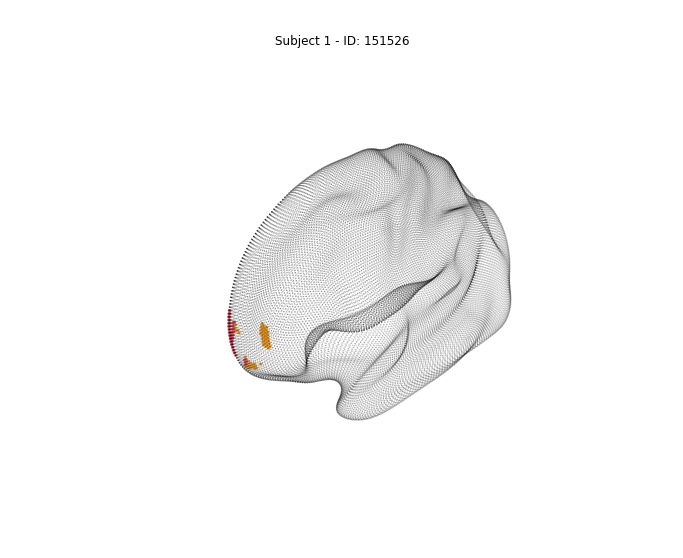

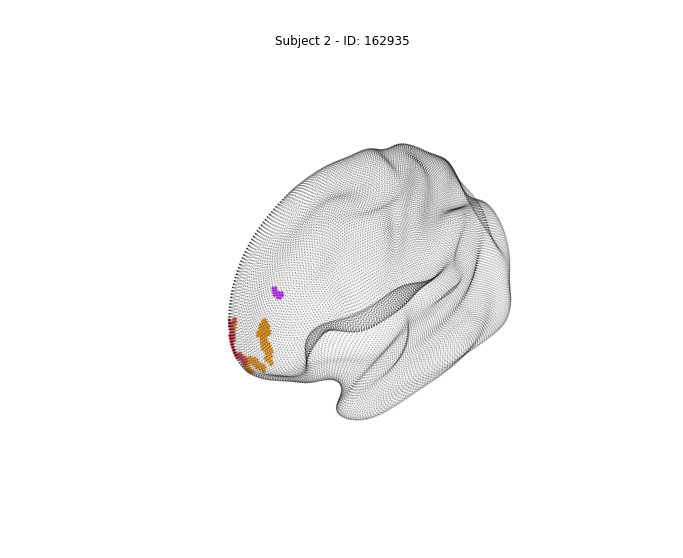

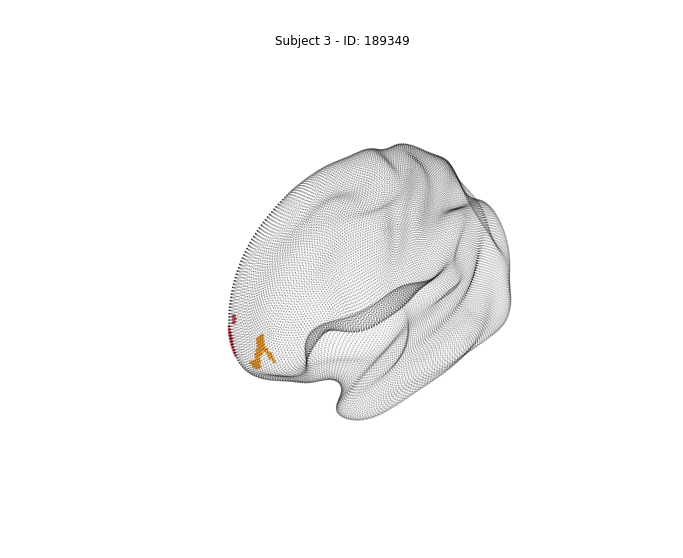

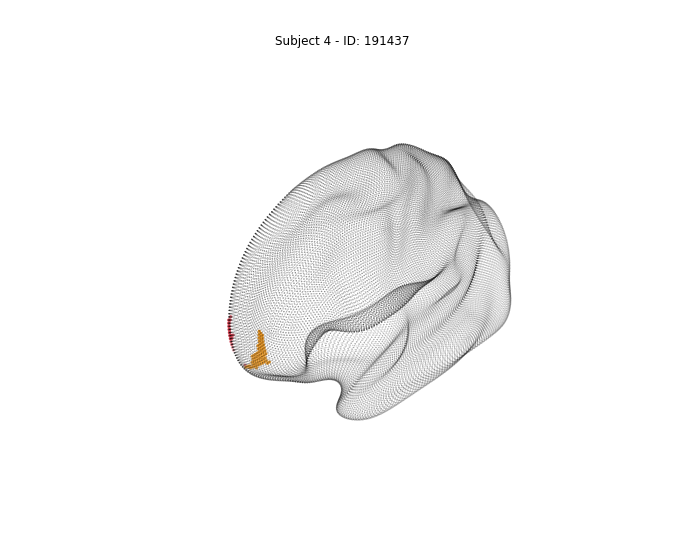

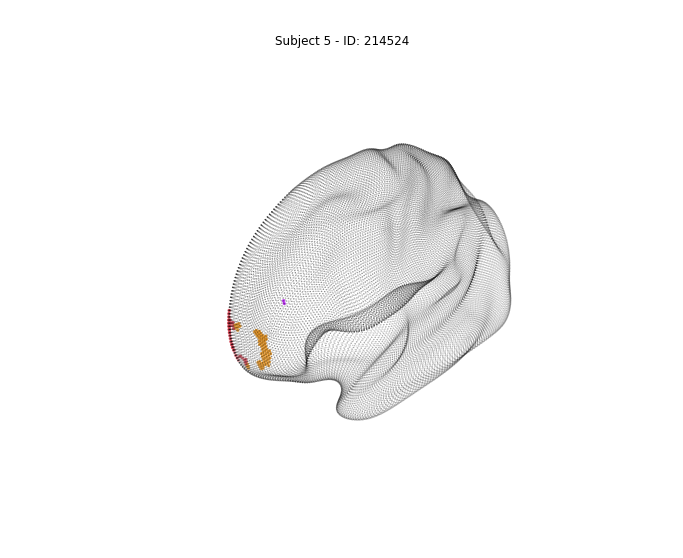

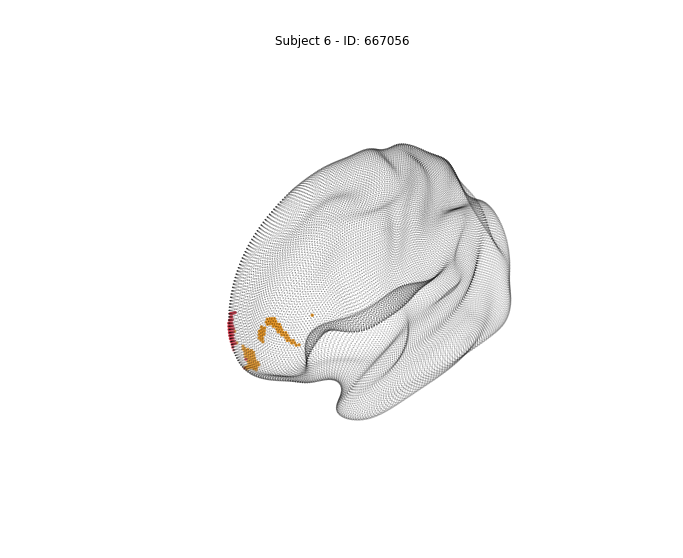

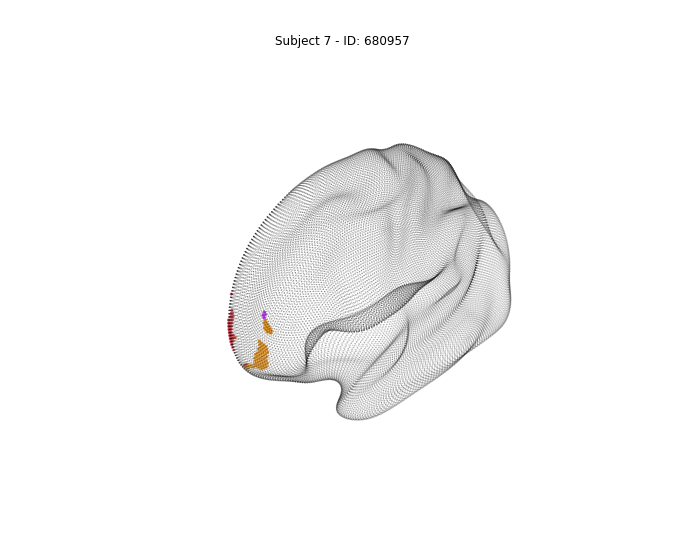

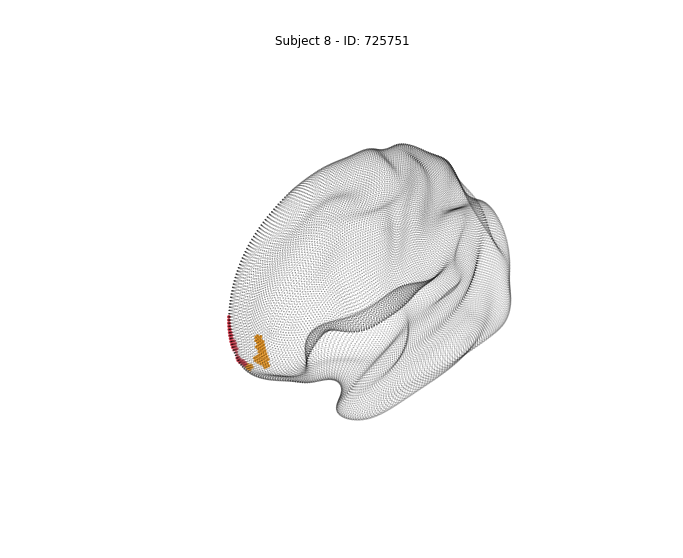

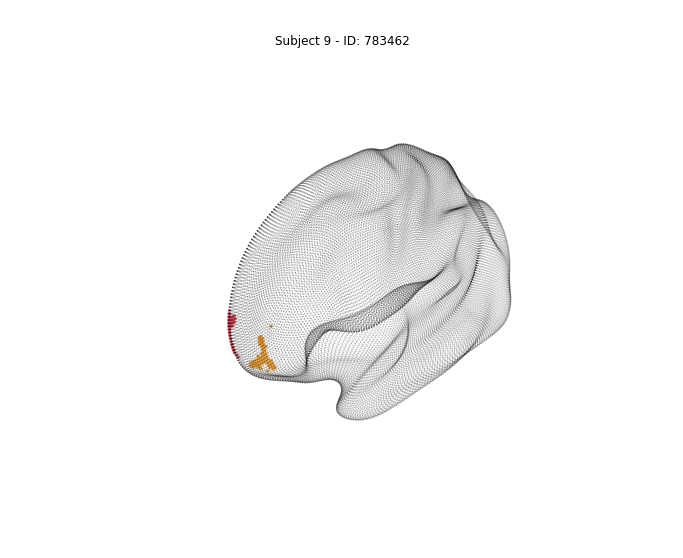

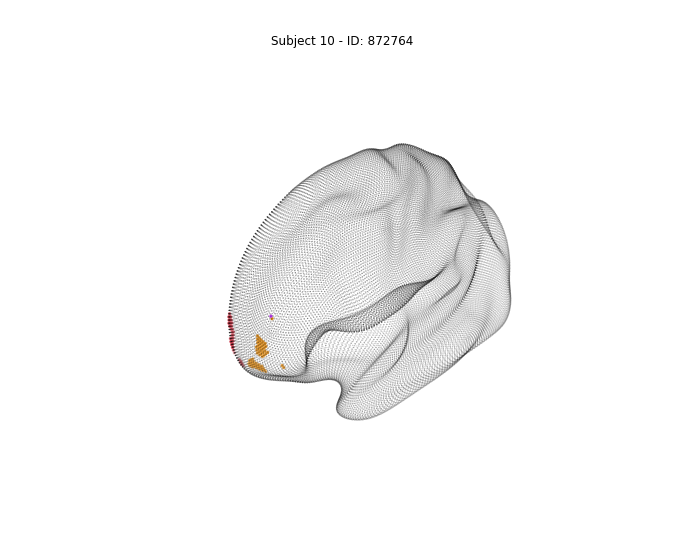

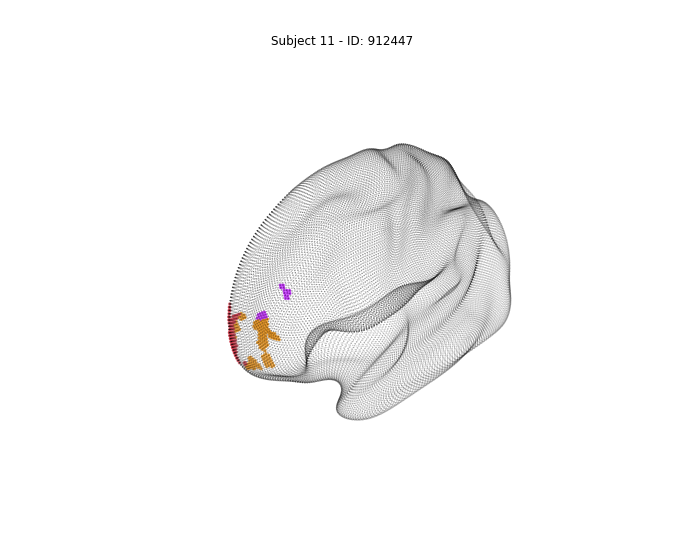

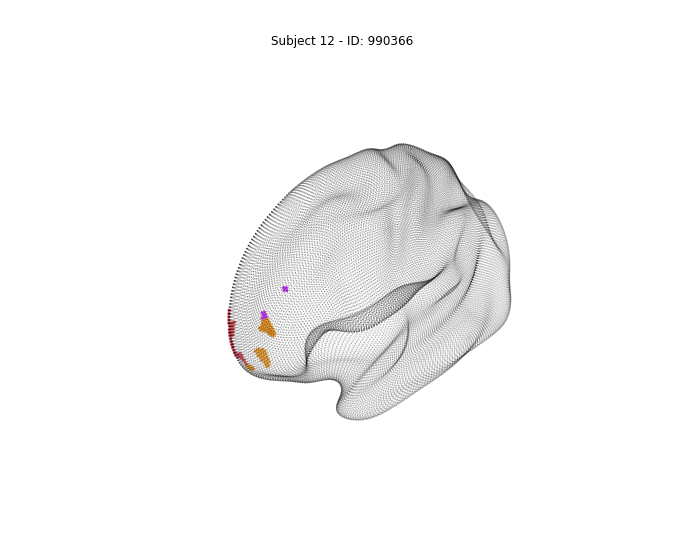

In [30]:
%%time
for j in range(len(sub_list)):
               
    all_ntwx_thresh = []
               
    for i in range(len(with_look_up_hcp_ofc_all_networks_df[j])):
        if (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][0]):
            all_ntwx_thresh.append(a1)
        elif (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][1]):
            all_ntwx_thresh.append(b1)
        elif (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][2]):
            all_ntwx_thresh.append(c1)
        elif (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][3]):
            all_ntwx_thresh.append(d1)
        elif (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][4]):
            all_ntwx_thresh.append(e1)
        elif (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][5]):
            all_ntwx_thresh.append(f1)
        elif (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][6]):
            all_ntwx_thresh.append(g1)
        elif (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][7]):
            all_ntwx_thresh.append(h1)
               
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'},figsize=(12,10))
    blah1 = ax.scatter(xinf,yinf,zinf,marker='.', s=0.1,c='k')
    # blah2 = ax.scatter(xr,yr,zr,marker='.', s=0.1,c='k')
    blah3 = ax.scatter(xinf[gii_all_subs_patches[j]],
               yinf[gii_all_subs_patches[j]],
               zinf[gii_all_subs_patches[j]],
               c=all_ntwx_thresh,
               cmap=cmap,norm=norm,s=5);
    ax.axis('off')
    ax.view_init(azim=145,elev=20) # use this azim, elev for opitz like angle on brain 
    ax.set_xlim([-100,100])
    plt.title('Subject {0} - ID: {1}'.format(j+1, sub_list[j]))

In [2]:
# Another angle

CPU times: user 6.32 s, sys: 150 ms, total: 6.47 s
Wall time: 6.46 s


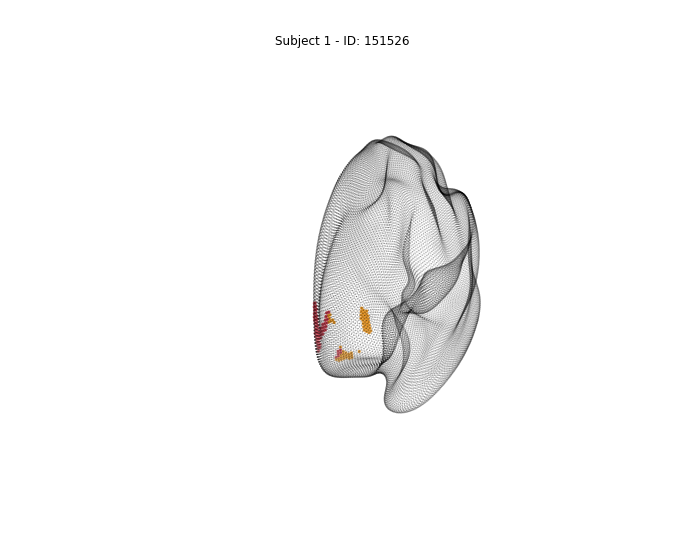

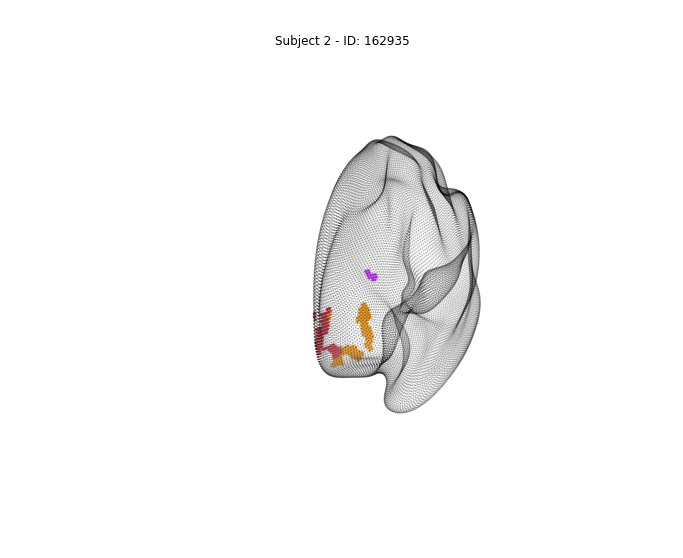

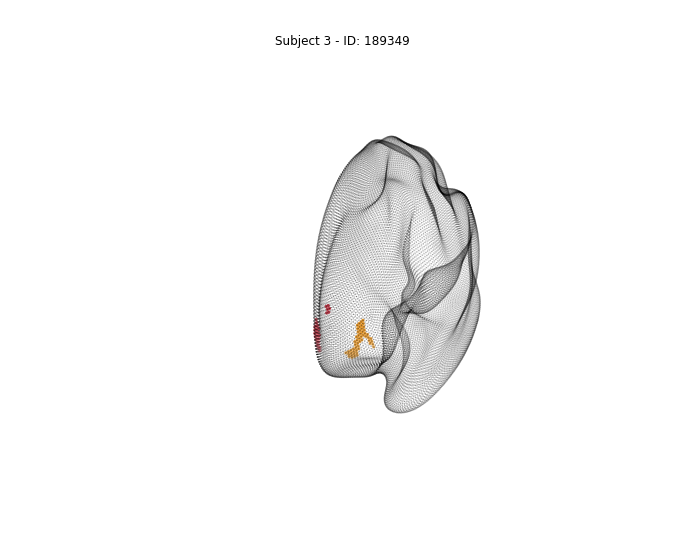

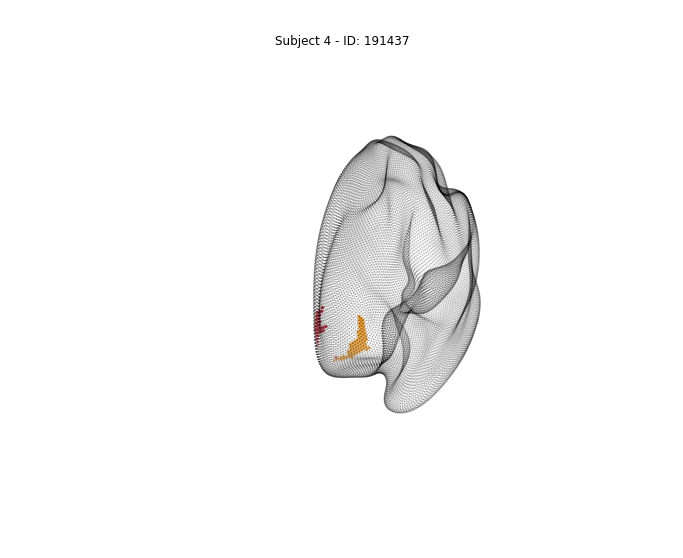

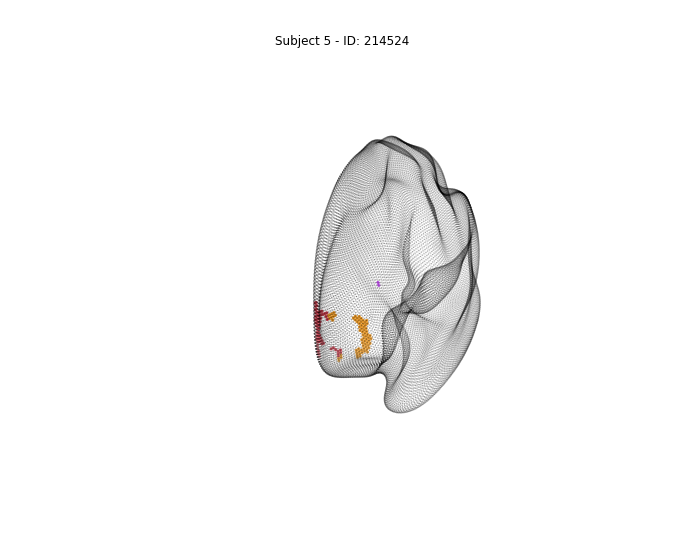

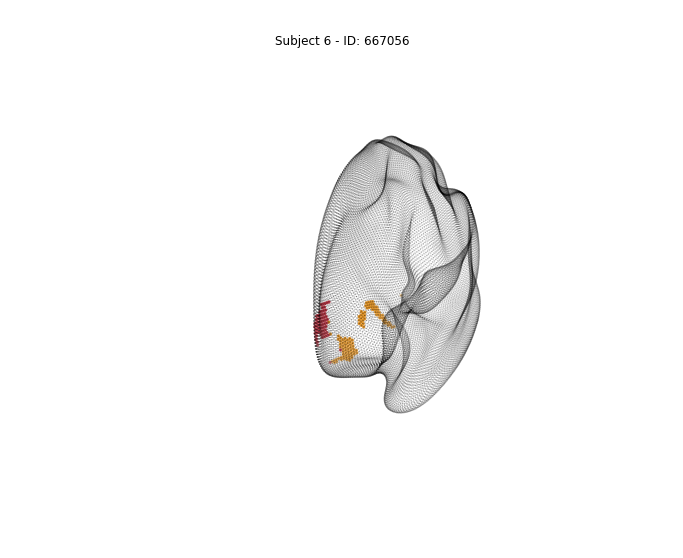

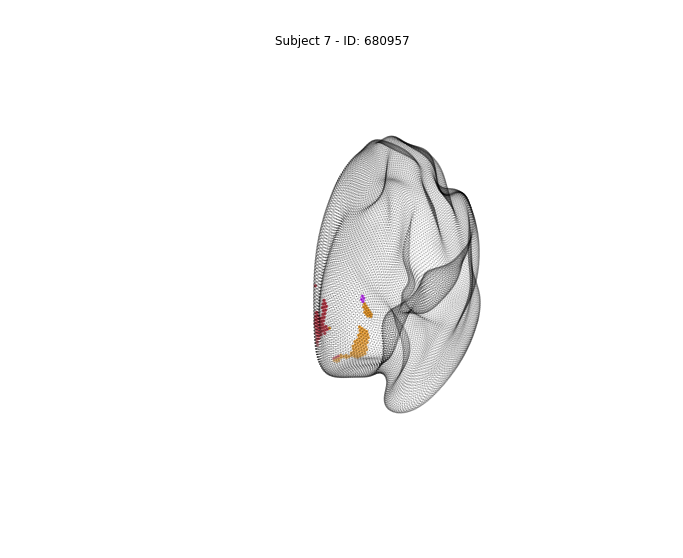

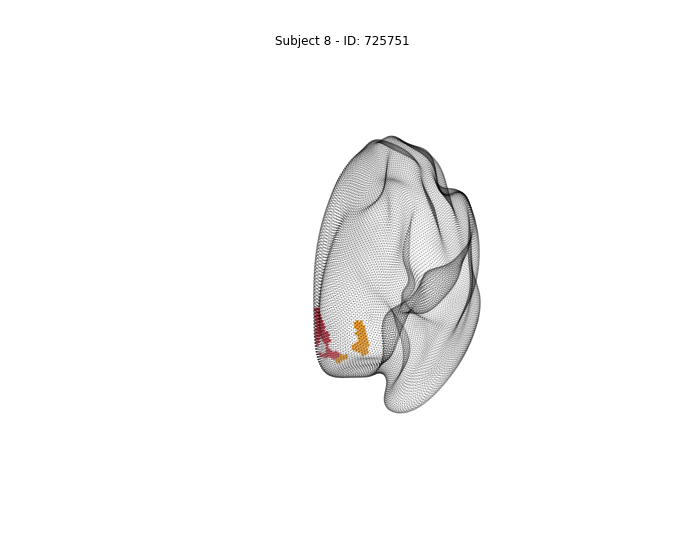

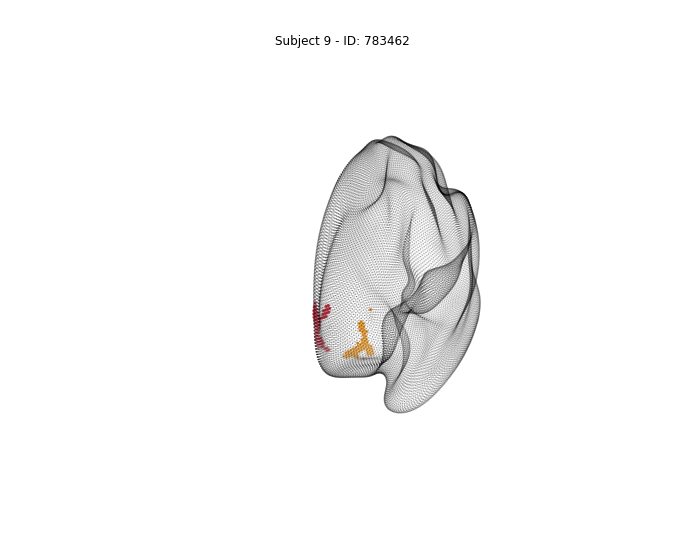

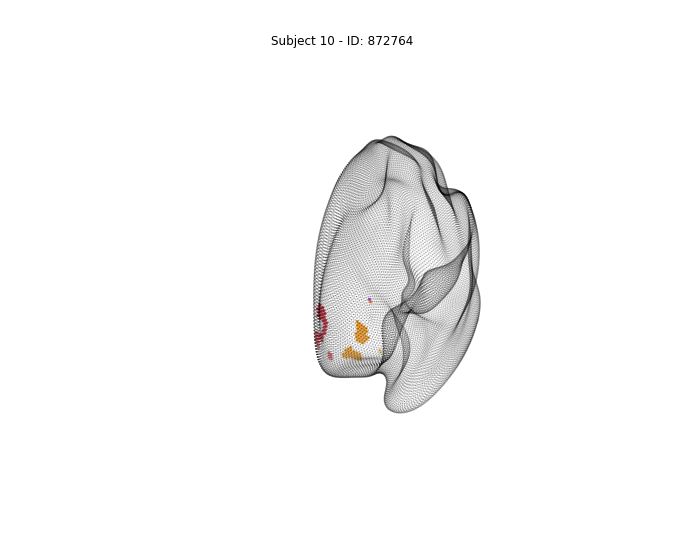

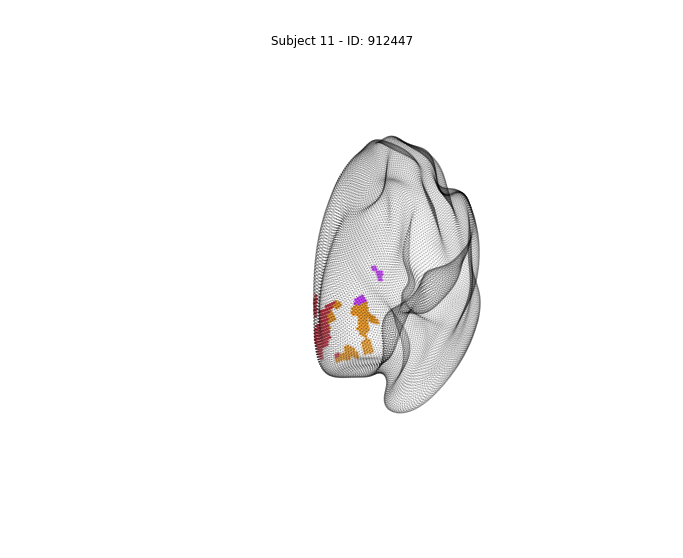

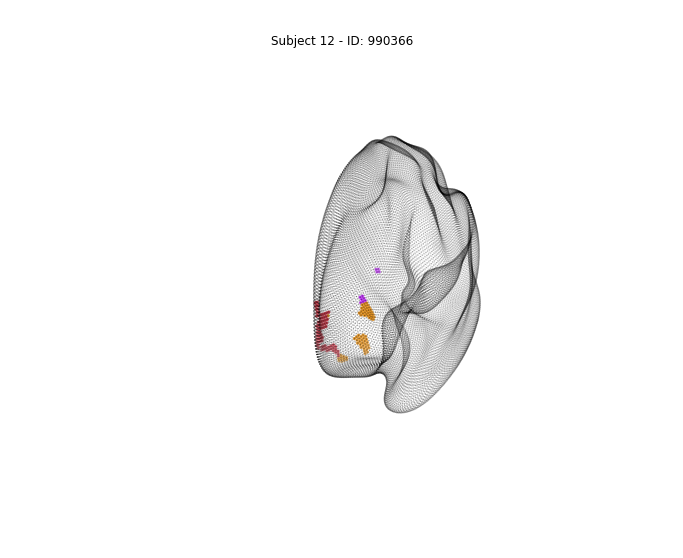

In [31]:
%%time
for j in range(len(sub_list)):
               
    all_ntwx_thresh = []
               
    for i in range(len(with_look_up_hcp_ofc_all_networks_df[j])):
        if (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][0]):
            all_ntwx_thresh.append(a1)
        elif (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][1]):
            all_ntwx_thresh.append(b1)
        elif (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][2]):
            all_ntwx_thresh.append(c1)
        elif (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][3]):
            all_ntwx_thresh.append(d1)
        elif (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][4]):
            all_ntwx_thresh.append(e1)
        elif (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][5]):
            all_ntwx_thresh.append(f1)
        elif (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][6]):
            all_ntwx_thresh.append(g1)
        elif (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][7]):
            all_ntwx_thresh.append(h1)
               
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'},figsize=(12,10))
    blah1 = ax.scatter(xinf,yinf,zinf,marker='.', s=0.1,c='k')
    # blah2 = ax.scatter(xr,yr,zr,marker='.', s=0.1,c='k')
    blah3 = ax.scatter(xinf[gii_all_subs_patches[j]],
               yinf[gii_all_subs_patches[j]],
               zinf[gii_all_subs_patches[j]],
               c=all_ntwx_thresh,
               cmap=cmap,norm=norm,s=5);
    ax.axis('off')
    ax.view_init(azim=110,elev=10) # use this azim, elev for opitz like angle on brain 
    ax.set_xlim([-100,100])
    plt.title('Subject {0} - ID: {1}'.format(j+1, sub_list[j]))

### % of E-field vtx with max FC to different functional networks

In [32]:
%%time
count_vis = np.zeros(len(sub_list))
count_sommot = np.zeros(len(sub_list))
count_dorsattn = np.zeros(len(sub_list))
count_ventattn = np.zeros(len(sub_list))
count_limbic = np.zeros(len(sub_list))
count_fpn = np.zeros(len(sub_list))
count_temppar = np.zeros(len(sub_list))
count_dmn = np.zeros(len(sub_list))

val_vis = []
val_sommot = []
val_dorsattn = []
val_ventattn = []
val_limbic = []
val_fpn = []
val_temppar = []
val_dmn = []

#ofc_ALL_networks_version_X[j].iloc[i])

for j in range(len(sub_list)):
    subj_vis = 0
    subj_sommot = 0
    subj_dorsattn = 0
    subj_ventattn = 0
    subj_limbic = 0
    subj_fpn = 0
    subj_temppar = 0
    subj_dmn = 0
    
    subj_val_vis = []
    subj_val_sommot = []
    subj_val_dorsattn = []
    subj_val_ventattn = []
    subj_val_limbic = []
    subj_val_fpn = []
    subj_val_temppar = []
    subj_val_dmn = []
    
    for i in range(len(with_look_up_hcp_ofc_all_networks_df[j])):
        if (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][0]):
            subj_vis = subj_vis + 1
            subj_val_vis.append(with_look_up_hcp_ofc_all_networks_df[j].iloc[i][0])
        elif (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][1]): 
            subj_sommot = subj_sommot + 1
            subj_val_sommot.append(with_look_up_hcp_ofc_all_networks_df[j].iloc[i][1])
        elif (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][2]): 
            subj_dorsattn = subj_dorsattn + 1
            subj_val_dorsattn.append(with_look_up_hcp_ofc_all_networks_df[j].iloc[i][2])
        elif (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][3]): 
            subj_ventattn = subj_ventattn + 1
            subj_val_ventattn.append(with_look_up_hcp_ofc_all_networks_df[j].iloc[i][3])
        elif (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][4]): 
            subj_limbic = subj_limbic + 1
            subj_val_limbic.append(with_look_up_hcp_ofc_all_networks_df[j].iloc[i][4])
        elif (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][5]): 
            subj_fpn = subj_fpn + 1
            subj_val_fpn.append(with_look_up_hcp_ofc_all_networks_df[j].iloc[i][5])
        elif (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][6]): 
            subj_temppar = subj_temppar + 1
            subj_val_temppar.append(with_look_up_hcp_ofc_all_networks_df[j].iloc[i][6])
        elif (max(with_look_up_hcp_ofc_all_networks_df[j].iloc[i]) == with_look_up_hcp_ofc_all_networks_df[j].iloc[i][7]): 
            subj_dmn = subj_dmn + 1
            subj_val_dmn.append(with_look_up_hcp_ofc_all_networks_df[j].iloc[i][7])
            
    
    count_vis[j] = subj_vis
    count_sommot[j] = subj_sommot
    count_dorsattn[j] = subj_dorsattn
    count_ventattn[j] = subj_ventattn
    count_limbic[j] = subj_limbic
    count_fpn[j] = subj_fpn
    count_temppar[j] = subj_temppar
    count_dmn[j] =  subj_dmn
    
    val_vis.insert(j, subj_val_vis)
    val_sommot.insert(j, subj_val_sommot)
    val_dorsattn.insert(j, subj_val_dorsattn)
    val_ventattn.insert(j, subj_val_ventattn)
    val_limbic.insert(j, subj_val_limbic)
    val_fpn.insert(j, subj_val_fpn)
    val_temppar.insert(j, subj_val_temppar)
    val_dmn.insert(j, subj_val_dmn)

    
count_vis = count_vis.tolist()
count_sommot = count_sommot.tolist()
count_dorsattn = count_dorsattn.tolist()
count_ventattn = count_ventattn.tolist()
count_limbic = count_limbic.tolist()
count_fpn = count_fpn.tolist()
count_temppar = count_temppar.tolist()
count_dmn = count_dmn.tolist()

CPU times: user 5.28 s, sys: 6.65 ms, total: 5.28 s
Wall time: 5.28 s


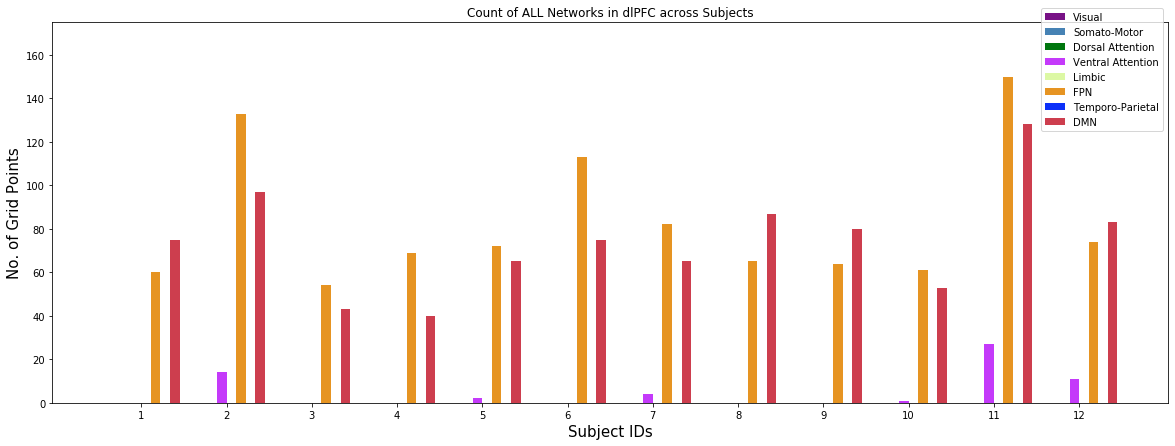

In [33]:


ind = np.arange(len(count_dmn))*4 # the x locations for dmn, fpn
barwidth = 0.45 # width of individual bars
fig, ax = plt.subplots(figsize =(20,7))
visbars = ax.bar(ind, count_vis, barwidth, color = '#781286',align = 'center')
sommotbars = ax.bar(ind+barwidth,count_sommot,barwidth, color = '#4682B4',align = 'center')
dorsattnbars = ax.bar(ind+(barwidth*2),count_dorsattn, barwidth, color = '#00760E',align = 'center')
ventattnbars = ax.bar(ind+(barwidth*3), count_ventattn, barwidth, color = '#C43AFA',align = 'center')
limbicbars = ax.bar(ind+(barwidth*4), count_limbic, barwidth, color = '#DCF8A4',align = 'center')
fpnbars = ax.bar(ind+(barwidth*5), count_fpn, barwidth, color = '#E69422',align = 'center')
tempparbars = ax.bar(ind+(barwidth*6), count_temppar, barwidth, color = '#0C30F9',align = 'center')
dmnbars = ax.bar(ind+(barwidth*7), count_dmn, barwidth, color = '#CD3E4E',align = 'center')

# add some text for labels, title and axes ticks
ax.set_ylabel('No. of Grid Points',size='15')
ax.set_ylim([0, 175])
ax.set_xlabel('Subject IDs',size='15')
ax.set_title('Count of ALL Networks in dlPFC across Subjects')
ax.set_xticks(ind + (barwidth*7) / 2)
ax.set_xticklabels(subs_list_nos)#, rotation=0,ha="centre")

ax.legend((visbars[0], sommotbars[0], dorsattnbars[0], ventattnbars[0], limbicbars[0], fpnbars[0], tempparbars[0], dmnbars[0]), ('Visual', 'Somato-Motor', 'Dorsal Attention', 'Ventral Attention', 'Limbic', 'FPN', 'Temporo-Parietal','DMN'),prop={'size':10},bbox_to_anchor=(1,1.05))
plt.show()

### as a %

In [34]:
sub_e_field_patch_sizes = []
for i in range(12):
    sub_e_field_patch_sizes.insert(i,len(with_look_up_hcp_ofc_all_networks_df[i]))

In [35]:
sub_e_field_patch_sizes

[135, 244, 97, 109, 139, 188, 151, 152, 144, 115, 305, 168]

In [36]:
np.mean(sub_e_field_patch_sizes)

162.25

In [37]:
np.std(sub_e_field_patch_sizes)

56.9577694436852

In [38]:
percent_count_vis = [(a/b)*100 for a, b in zip(count_vis, sub_e_field_patch_sizes)]
percent_count_sommot = [(a/b)*100 for a, b in zip(count_sommot, sub_e_field_patch_sizes)]
percent_count_dorsattn = [(a/b)*100 for a, b in zip(count_dorsattn, sub_e_field_patch_sizes)]
percent_count_ventattn = [(a/b)*100 for a, b in zip(count_ventattn, sub_e_field_patch_sizes)]
percent_count_limbic = [(a/b)*100 for a, b in zip(count_limbic, sub_e_field_patch_sizes)]
percent_count_fpn = [(a/b)*100 for a, b in zip(count_fpn, sub_e_field_patch_sizes)]
percent_count_temppar = [(a/b)*100 for a, b in zip(count_temppar, sub_e_field_patch_sizes)]
percent_count_dmn = [(a/b)*100 for a, b in zip(count_dmn, sub_e_field_patch_sizes)]

data = {'Visual % vtx': percent_count_vis,
        'SomMot % vtx': percent_count_sommot,
        'DorsAttn % vtx': percent_count_dorsattn, 
        'VentAttn % vtx': percent_count_ventattn,
        'Limbic % vtx': percent_count_limbic,
        'Fronto-Parietal % vtx': percent_count_fpn,
        'Temporo-Parietal % vtx': percent_count_temppar,
        'Default-Mode % vtx': percent_count_dmn}

percent_vtx_df = pd.DataFrame(data)

percent_vtx_df.to_pickle("OFC_ss_efield_const_fc.pkl")

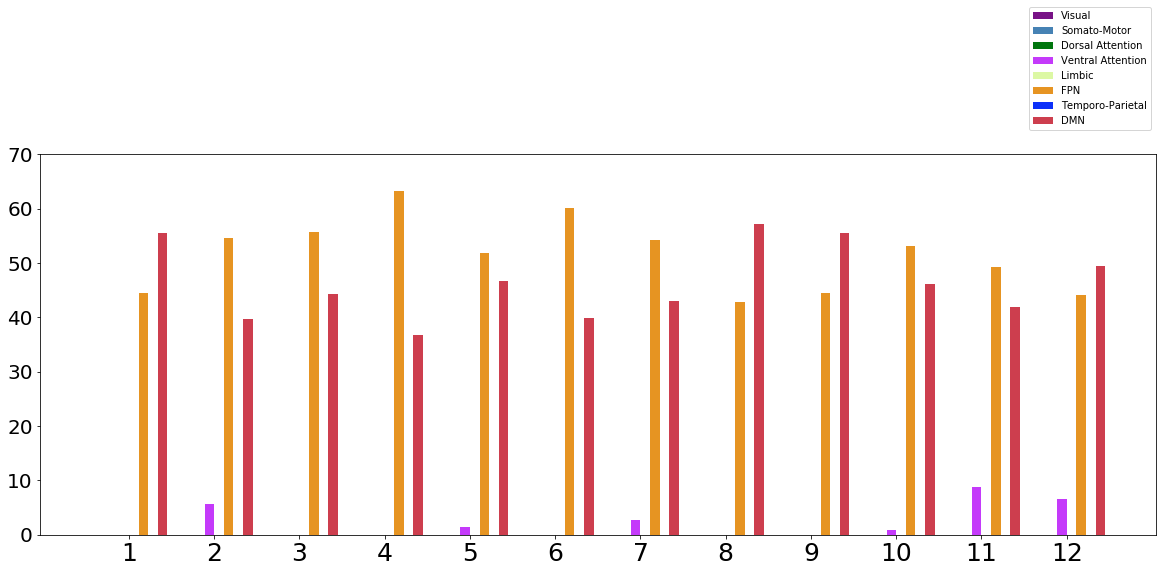

In [42]:
#colors = ['purple', 'steelblue', 'green', 'violet', 'khaki', 'orange', 'blue', 'red']

ind = np.arange(len(percent_count_dmn))*4 # the x locations for dmn, fpn
barwidth = 0.45 # width of individual bars
fig, ax = plt.subplots(figsize =(20,7))
visbars = ax.bar(ind, percent_count_vis, barwidth, color = '#781286',align = 'center')
sommotbars = ax.bar(ind+barwidth,percent_count_sommot,barwidth, color = '#4682B4',align = 'center')
dorsattnbars = ax.bar(ind+(barwidth*2),percent_count_dorsattn, barwidth, color = '#00760E',align = 'center')
ventattnbars = ax.bar(ind+(barwidth*3), percent_count_ventattn, barwidth, color = '#C43AFA',align = 'center')
limbicbars = ax.bar(ind+(barwidth*4), percent_count_limbic, barwidth, color = '#DCF8A4',align = 'center')
fpnbars = ax.bar(ind+(barwidth*5), percent_count_fpn, barwidth, color = '#E69422',align = 'center')
tempparbars = ax.bar(ind+(barwidth*6), percent_count_temppar, barwidth, color = '#0C30F9',align = 'center')
dmnbars = ax.bar(ind+(barwidth*7), percent_count_dmn, barwidth, color = '#CD3E4E',align = 'center')

# add some text for labels, title and axes ticks
# ax.set_ylabel('% of Grid Points',size='15')
plt.yticks(fontsize=20)
ax.set_ylim([0, 70])
# ax.set_xlabel('Subject IDs',size='15')
# ax.set_title('percent_count of ALL Networks in dlPFC across Subjects')
ax.set_xticks(ind + (barwidth*7) / 2)
ax.set_xticklabels(subs_list_nos,size='25')#, rotation=0,ha="centre")

ax.legend((visbars[0], sommotbars[0], dorsattnbars[0], ventattnbars[0], limbicbars[0], fpnbars[0], tempparbars[0], dmnbars[0]), ('Visual', 'Somato-Motor', 'Dorsal Attention', 'Ventral Attention', 'Limbic', 'FPN', 'Temporo-Parietal','DMN'),prop={'size':10},bbox_to_anchor=(1,1.4))
plt.show()

In [39]:
def spider_plot(excel_labels, values2plot, colour=None, linestyle=None, linecolour=None,
                linewidth=None, label_colour=None, label_size=None, alpha=None,
                ylim=None):

    '''
    spider plot of network measures in percentage
    Parameters
    ----------
    excel_labels: excel file |
        please se example available in the repo (e.g. network_colour.xlsx)
    values2plot: np.array |
        values to plot must have the same dimension of excel_labels
    colour (optional) = scalar or array-like, optional
        set the colors of the plot (Default is 'orange')
    linestyle (optional) :  str |
        set the patch linestyle (e.g. '-' or 'solid', '--' or 'dashed', '-.'
        or 'dashdot', ':' or 'dotted') (Default is 'solid')
    linecolour (optional): float |
        set the colors of the line (Default is 'orange')
    linewidth (optional): scalar or array-like, optional
        Width of the bar edge(s). If 0, don't draw edges. (Default is 1)
    label_colour: scalar or array-like, optional
        set the colors of the labels (Default is 'black')
    label_size (optional): scalar |
        set the size of labels (Default is 8)
    alpha (optional): float |
        set the alpha transparency of the patch (Default is 0.5)
    ylim (optional): scalar |
        (by default it will automatically adjust the ylim)
    '''

    if alpha==None:
        alpha = 0.5
    else:
        alpha= alpha

    if label_colour==None:
        label_colour='black'
    else:
        label_colour=label_colour

    if label_size==None:
        label_size=8
    else:
        label_size=label_size

    if linewidth==None:
        linewidth=1
    else:
        linewidth=linewidth

    if linecolour==None:
        linecolour='orange'
    else:
        linecolour=linecolour

    if linestyle==None:
        linestyle='solid'
    else:
        linestyle=linestyle

    if colour==None:
        colour= 'orange'
    else:
        colour=colour

    labels = list(np.array(pd.read_excel(excel_labels,  engine='openpyxl', header=None))[:,0])
    values = values2plot * 100 / np.sum(values2plot)

    if ylim==None:
        ylim= np.max(values) + (10 - np.max(values)  % 10)
    else:
        ylim=ylim

    values = values.tolist()
    values += values[:1]
    N = len(labels)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    ax = plt.subplot(111, polar=True)

    plt.xticks(angles, labels, color=label_colour, size=label_size)

    ax.set_rlabel_position(0)
    plt.ylim(0,ylim)

    ax.plot(angles, values, linecolour , linewidth=linewidth, linestyle=linestyle)

    ax.fill(angles, values, colour, alpha=alpha)
    plt.show()

In [40]:
all_subs_percent_df = pd.DataFrame({'Visual': percent_count_vis, 'Somato-Motor': percent_count_sommot,
                                    'Dorsal Attention': percent_count_dorsattn, 'Ventral Attention': percent_count_ventattn,
                                    'Limbic': percent_count_limbic, 'Fronto-Parietal': percent_count_fpn,
                                    'Temporo-Parietal': percent_count_temppar, 'Default-Mode': percent_count_dmn})

1


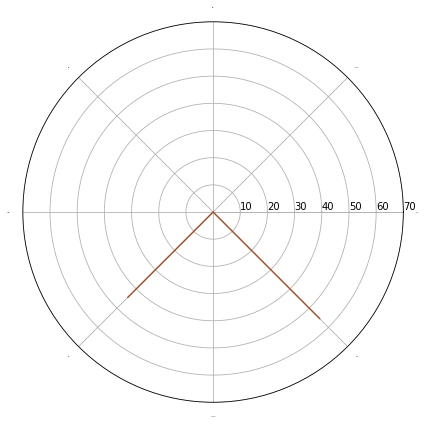

2


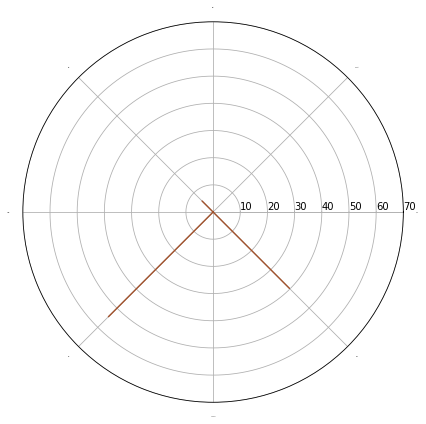

3


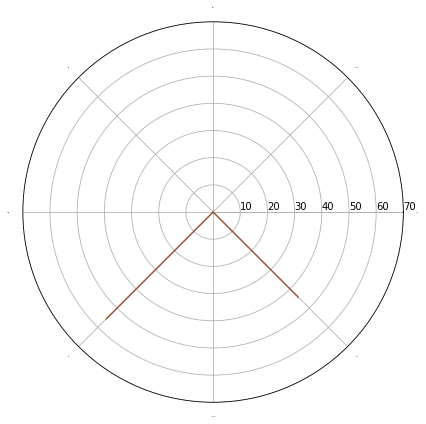

4


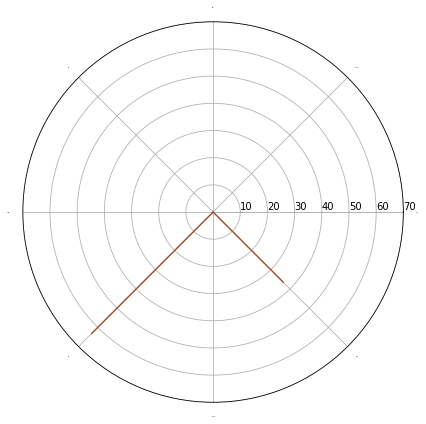

5


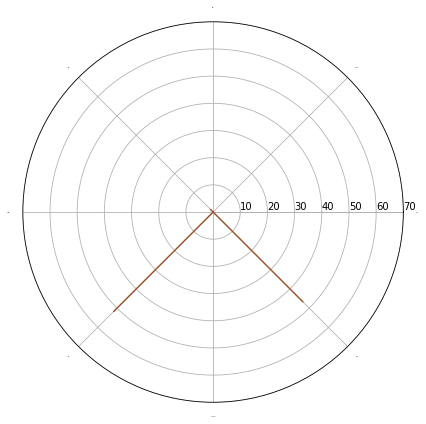

6


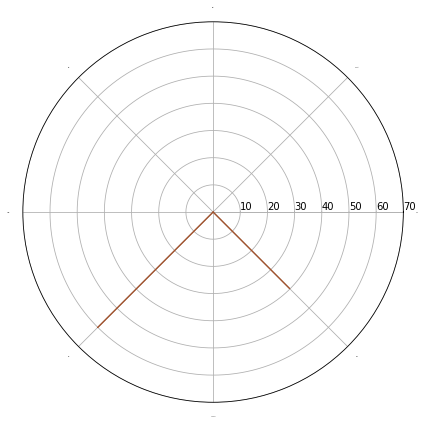

7


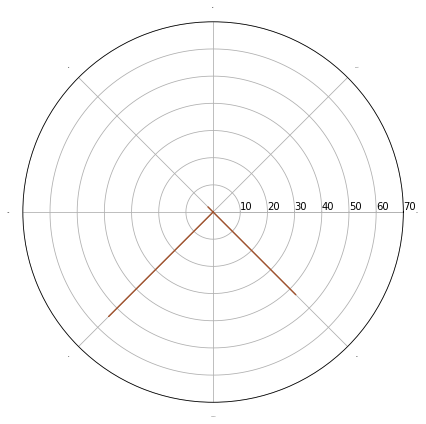

8


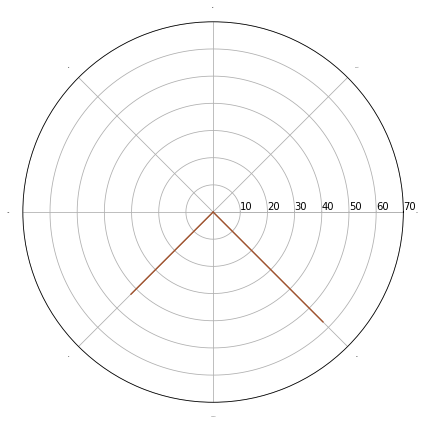

9


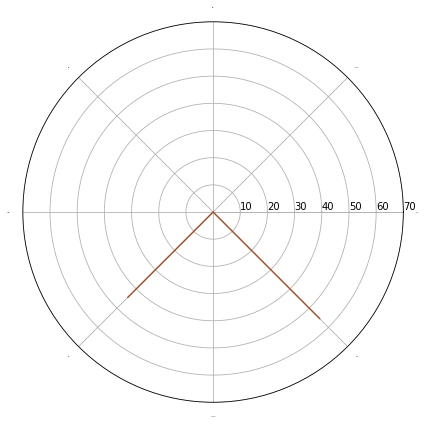

10


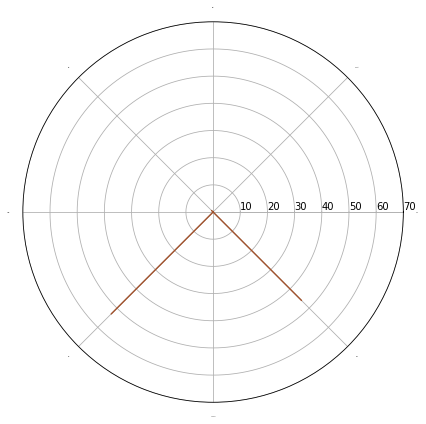

11


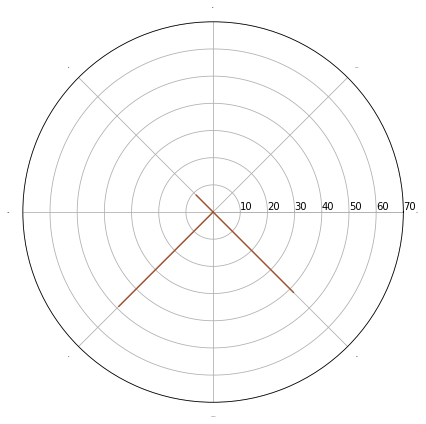

12


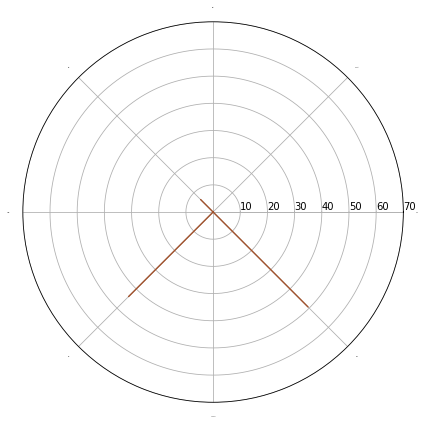

In [41]:
for i in range(12):
    print(i+1)
    fig, ax = plt.subplots(figsize=(9,7))
    spider_plot('network_colour.xlsx',all_subs_percent_df.iloc[i].values,label_size=0.1,ylim=70,alpha=1,colour='sienna',linecolour='sienna')
    
#     plt.title('Subject - {0}'.format(i))

In [42]:
sum_percent_count = [a+b for a, b, in zip(percent_count_fpn,percent_count_dmn)]

In [43]:
np.mean(sum_percent_count)

97.82539968809863

In [44]:
print(np.min(percent_count_fpn), np.max(percent_count_fpn), np.mean(percent_count_fpn), np.std(percent_count_fpn))

42.76315789473684 63.30275229357798 51.467841996669314 6.37018989796173


In [45]:
print(np.min(percent_count_dmn), np.max(percent_count_dmn), np.mean(percent_count_dmn), np.std(percent_count_dmn))

36.69724770642202 57.23684210526315 46.357557691429314 6.520149929400875


In [46]:
np.mean(sum_percent_count)

97.82539968809863

### Functional Connectivity Maps

#### Individual Subs ...

In [43]:
%%time
all_subs_e_fields_func_conns = []
for i in range(len(sub_list)):
    tot_lh_dat_all_vtx = np.zeros(mt_vtx.shape[0])
    gii_dat = subj_gii_dat[i] # e-field
    gii_dat_thr9_bin = (gii_dat>=0.9).astype(float)
    gii_patch_val = 1.
    gii_patch_idx_9 = np.nonzero(gii_dat_thr9_bin==gii_patch_val)[0]
    for y in range(len(gii_patch_idx_9)):
        vtxnum = gii_patch_idx_9[y]
        vtxnum_idx = np.nonzero(lh_idxs==vtxnum)[0]
        vtxnum_idx = vtxnum_idx[0]
        lh_dat = np.zeros_like(mt_vtx[:,0])
        lh_dat[lh_idxs[:,1]] = dconn_dat[lh_idxs[:,0],vtxnum_idx]
        tot_lh_dat_all_vtx = tot_lh_dat_all_vtx + lh_dat
    
    avg_lh_dat_all_vtx = tot_lh_dat_all_vtx/len(gii_patch_idx_9)
    avg_lh_dat_all_vtx = np.array(avg_lh_dat_all_vtx)
    
    all_subs_e_fields_func_conns.insert(i,avg_lh_dat_all_vtx)

CPU times: user 1.4 s, sys: 27 ms, total: 1.43 s
Wall time: 1.42 s


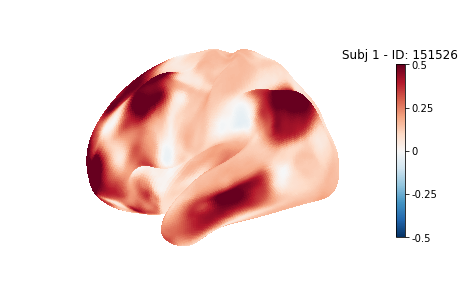

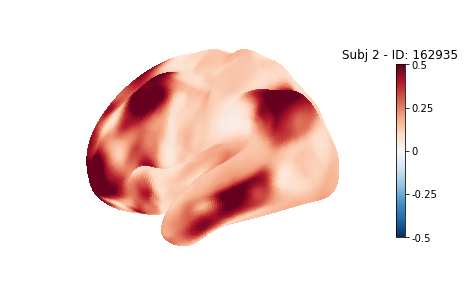

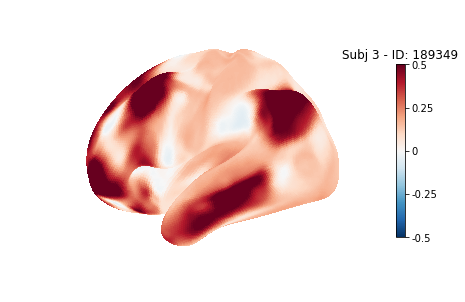

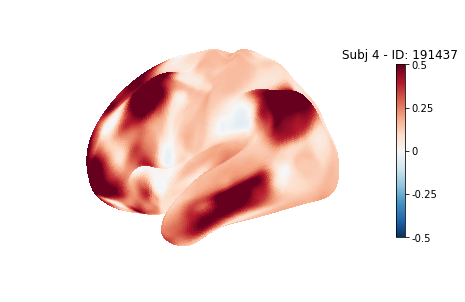

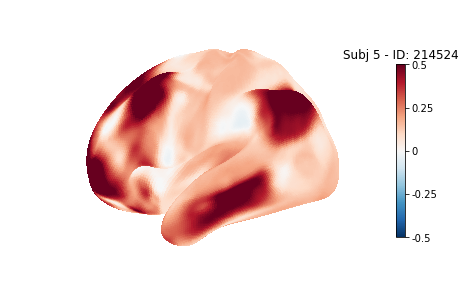

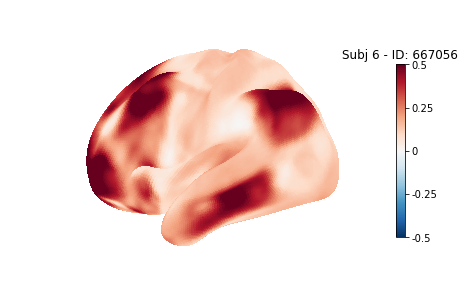

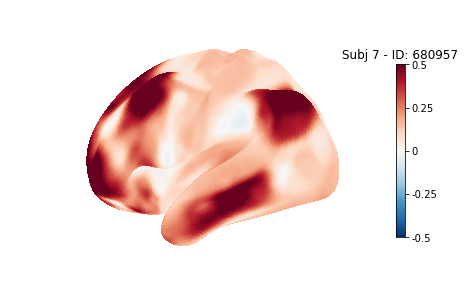

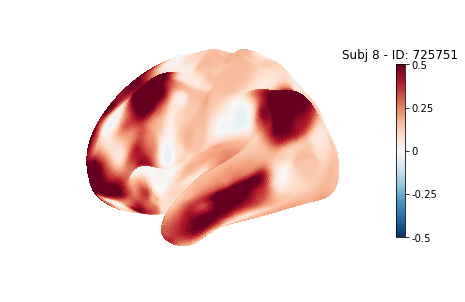

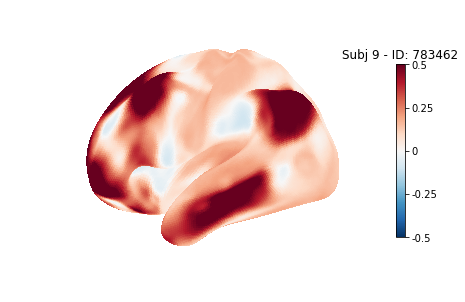

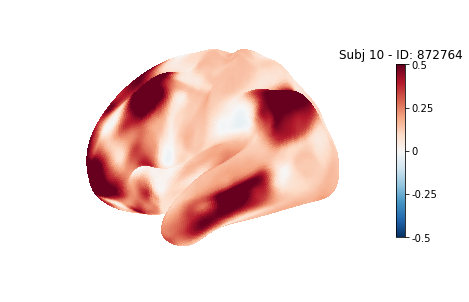

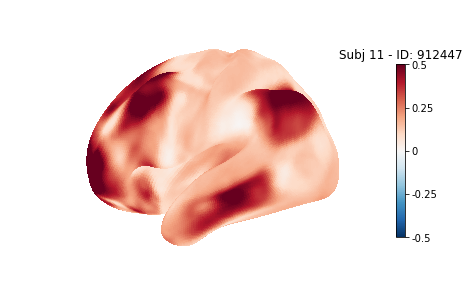

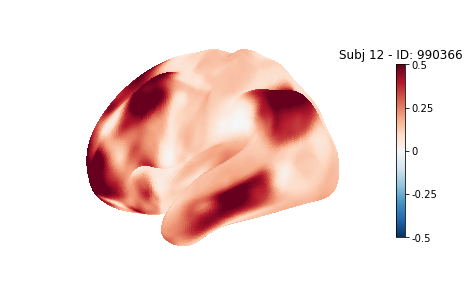

CPU times: user 1min 51s, sys: 1.49 s, total: 1min 53s
Wall time: 1min 53s


In [44]:
%%time
for i in range(len(sub_list)):
    disp = plot_surf_stat_map([inf_vtx,inf_tri],all_subs_e_fields_func_conns[i],cmap='RdBu_r',hemi='left',view='lateral',vmax=0.5)#, threshold=0.2)
    plt.title('Subj %s - ID: %s' % ((i+1), sub_list[i]))
    plt.show()

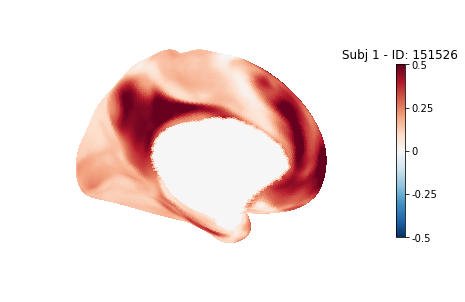

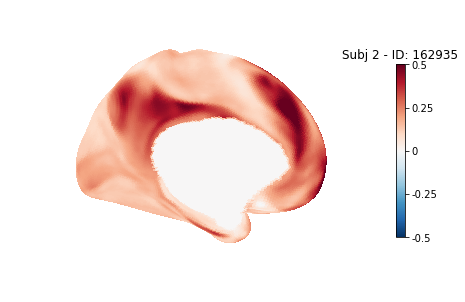

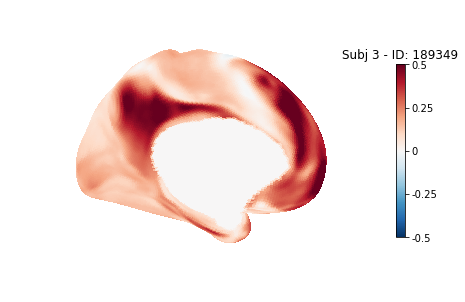

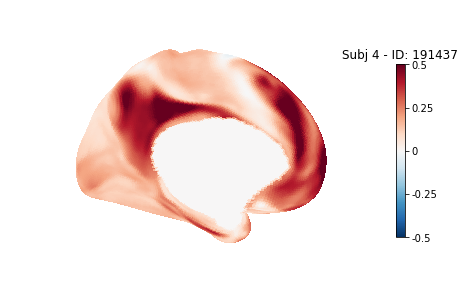

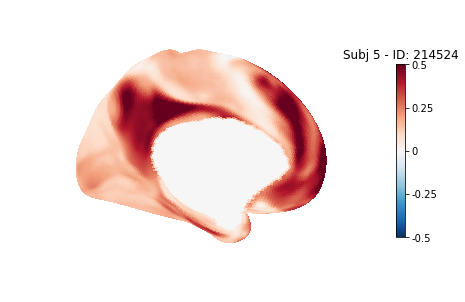

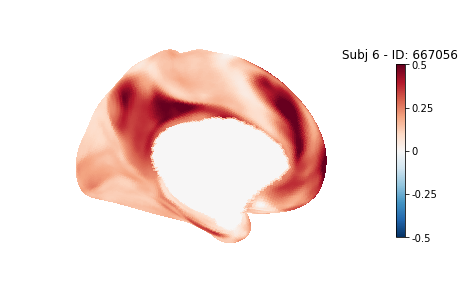

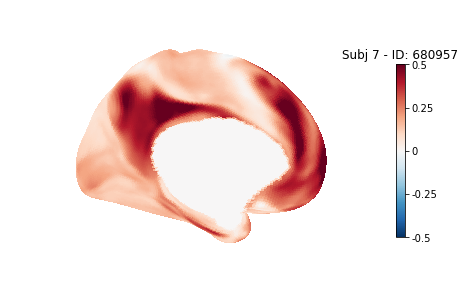

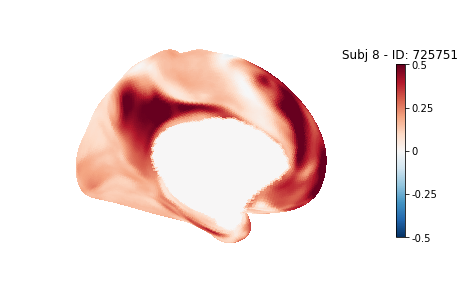

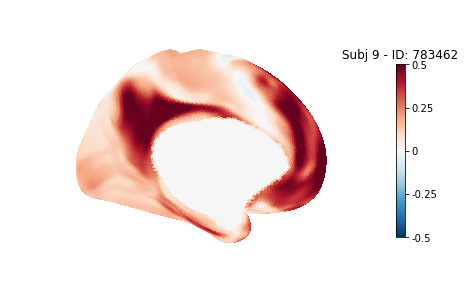

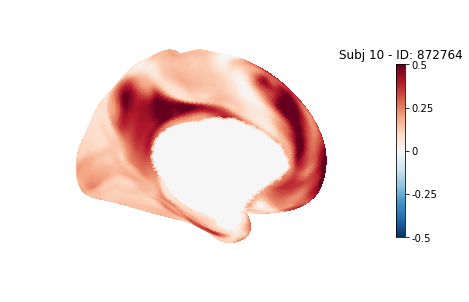

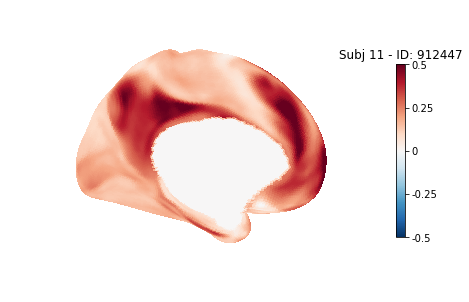

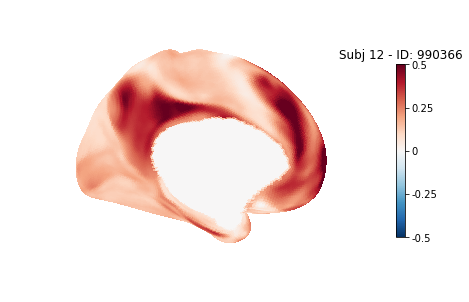

CPU times: user 1min 51s, sys: 1.3 s, total: 1min 52s
Wall time: 1min 52s


In [45]:
%%time
for i in range(len(sub_list)):
    disp = plot_surf_stat_map([inf_vtx,inf_tri],all_subs_e_fields_func_conns[i],cmap='RdBu_r',hemi='left',view='medial',vmax=0.5)#, threshold=0.2)
    plt.title('Subj %s - ID: %s' % ((i+1), sub_list[i]))
    plt.show()

# -----------------------------------------------------------------------------------------------------------

# Graveyard

### Average FC

In [26]:
with_avg_func_conn_across_all_vtx = []
for i in range(12):
    with_avg_func_conn_across_all_vtx.insert(i, with_look_up_hcp_ofc_all_networks_df[i].mean(axis=0) )

In [27]:
with_avg_vis_fc = np.zeros(len(sub_list))
with_avg_sommot_fc = np.zeros(len(sub_list))
with_avg_dorsattn_fc = np.zeros(len(sub_list))
with_avg_ventattn_fc = np.zeros(len(sub_list))
with_avg_limbic_fc = np.zeros(len(sub_list))
with_avg_fpn_fc = np.zeros(len(sub_list))
with_avg_temppar_fc = np.zeros(len(sub_list))
with_avg_dmn_fc = np.zeros(len(sub_list))

for i in range(12):
    with_avg_vis_fc[i] = with_avg_func_conn_across_all_vtx[i][0]
    with_avg_sommot_fc[i] = with_avg_func_conn_across_all_vtx[i][1]
    with_avg_dorsattn_fc[i] = with_avg_func_conn_across_all_vtx[i][2]
    with_avg_ventattn_fc[i] = with_avg_func_conn_across_all_vtx[i][3]
    with_avg_limbic_fc[i] = with_avg_func_conn_across_all_vtx[i][4]
    with_avg_fpn_fc[i] = with_avg_func_conn_across_all_vtx[i][5]
    with_avg_temppar_fc[i] = with_avg_func_conn_across_all_vtx[i][6]
    with_avg_dmn_fc[i] = with_avg_func_conn_across_all_vtx[i][7]

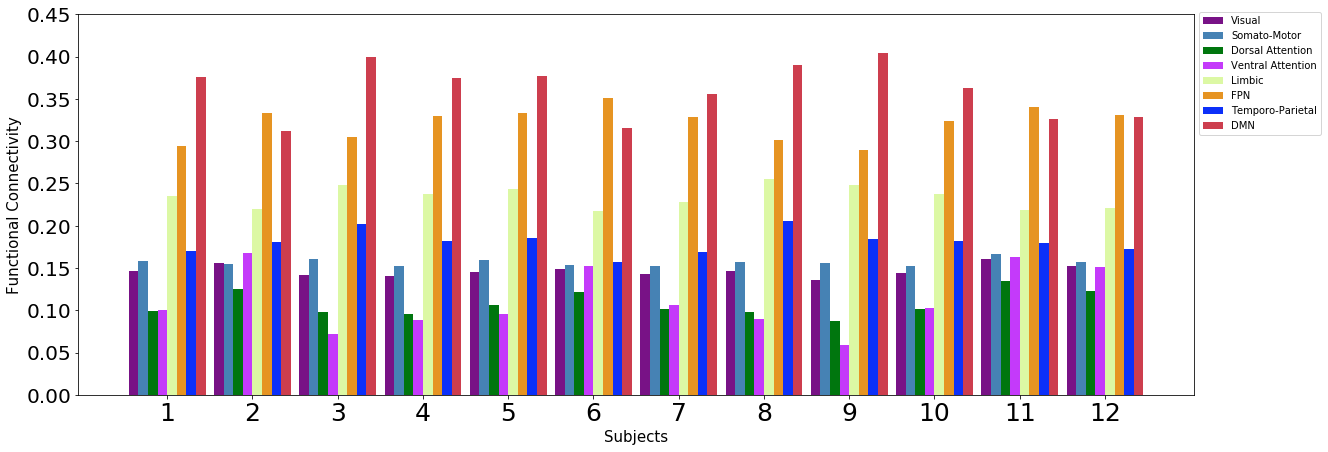

In [28]:
#colors = ['purple', 'steelblue', 'green', 'violet', 'khaki', 'orange', 'blue', 'red']

ind = np.arange(len(sub_list))*4 # the x locations for dmn, fpn
barwidth = 0.45 # width of individual bars
fig, ax = plt.subplots(figsize =(20,7))
with_avg_visbars = ax.bar(ind, with_avg_vis_fc, barwidth, color = '#781286',align = 'center')
with_avg_sommotbars = ax.bar(ind+barwidth,with_avg_sommot_fc,barwidth, color = '#4682B4',align = 'center')
with_avg_dorsattnbars = ax.bar(ind+(barwidth*2),with_avg_dorsattn_fc, barwidth, color = '#00760E',align = 'center')
with_avg_ventattnbars = ax.bar(ind+(barwidth*3), with_avg_ventattn_fc, barwidth, color = '#C43AFA',align = 'center')
with_avg_limbicbars = ax.bar(ind+(barwidth*4), with_avg_limbic_fc, barwidth, color = '#DCF8A4',align = 'center')
with_avg_fpnbars = ax.bar(ind+(barwidth*5), with_avg_fpn_fc, barwidth, color = '#E69422',align = 'center')
with_avg_tempparbars = ax.bar(ind+(barwidth*6), with_avg_temppar_fc, barwidth, color = '#0C30F9',align = 'center')
with_avg_dmnbars = ax.bar(ind+(barwidth*7), with_avg_dmn_fc, barwidth, color = '#CD3E4E',align = 'center')

# add some text for labels, title and axes ticks
ax.set_ylabel('Functional Connectivity',size='15')
plt.yticks(fontsize=20)
ax.set_ylim([0, 0.45])
ax.set_xlabel('Subjects',size='15')
# ax.set_title('Avg FC of ALL Networks in dlPFC across Subjects')
ax.set_xticks(ind + (barwidth*7) / 2)
ax.set_xticklabels(subs_list_nos,size='25')#, rotation=0,ha="centre")

ax.legend((with_avg_visbars[0], with_avg_sommotbars[0], with_avg_dorsattnbars[0], with_avg_ventattnbars[0], with_avg_limbicbars[0], with_avg_fpnbars[0], with_avg_tempparbars[0], with_avg_dmnbars[0]), ('Visual', 'Somato-Motor', 'Dorsal Attention', 'Ventral Attention', 'Limbic', 'FPN', 'Temporo-Parietal','DMN'),prop={'size':10},bbox_to_anchor=(1,1.02))
plt.show()

In [29]:
# for the figure above ...

# Number of subs with DMN > FPN = 9 
# (Subs 1, 3, 4, 5, 7, 8, 9, 10, 12)

# Number of subs with FPN > DMN = 3 
# (Subs 2, 6, 11)

print(round(np.mean(with_avg_dmn_fc),2))
print(round(np.mean(with_avg_fpn_fc),2))

0.36
0.32


### Putting some numbers on it ...

In [57]:
%%time

avg_max_val_vis = []
avg_max_val_sommot = []
avg_max_val_dorsattn = []
avg_max_val_ventattn = []
avg_max_val_limbic = []
avg_max_val_fpn = []
avg_max_val_temppar = []
avg_max_val_dmn = []

max_max_val_vis = []
max_max_val_sommot = []
max_max_val_dorsattn = []
max_max_val_ventattn = []
max_max_val_limbic = []
max_max_val_fpn = []
max_max_val_temppar = []
max_max_val_dmn = []

min_max_val_vis = []
min_max_val_sommot = []
min_max_val_dorsattn = []
min_max_val_ventattn = []
min_max_val_limbic = []
min_max_val_fpn = []
min_max_val_temppar = []
min_max_val_dmn = []

for i in range(12):
    
    avg_max_val_vis.insert(i, np.mean(val_vis[i]))
    avg_max_val_sommot.insert(i, np.mean(val_sommot[i]))
    avg_max_val_dorsattn.insert(i, np.mean(val_dorsattn[i]))
    avg_max_val_ventattn.insert(i, np.mean(val_ventattn[i]))
    avg_max_val_limbic.insert(i, np.mean(val_limbic[i]))
    avg_max_val_fpn.insert(i, np.mean(val_fpn[i]))
    avg_max_val_temppar.insert(i, np.mean(val_temppar[i]))
    avg_max_val_dmn.insert(i, np.mean(val_dmn[i]))
    
    if len(val_vis[i]) > 0:
        max_max_val_vis.insert(i,max(val_vis[i]))
    if len(val_sommot[i]) > 0:
        max_max_val_sommot.insert(i,max(val_sommot[i]))
    if len(val_dorsattn[i]) > 0:    
        max_max_val_dorsattn.insert(i,max(val_dorsattn[i]))
    if len(val_ventattn[i]) > 0:
        max_max_val_ventattn.insert(i,max(val_ventattn[i]))
    if len(val_limbic[i]) > 0:
        max_max_val_limbic.insert(i,max(val_limbic[i]))
    if len(val_fpn[i]) > 0:
        max_max_val_fpn.insert(i,max(val_fpn[i]))
    if len(val_temppar[i]) > 0:
        max_max_val_temppar.insert(i,max(val_temppar[i]))
    if len(val_dmn[i]) > 0:
        max_max_val_dmn.insert(i,max(val_dmn[i]))

    if len(val_vis[i]) > 0:
        min_max_val_vis.insert(i,min(val_vis[i]))
    if len(val_sommot[i]) > 0:
        min_max_val_sommot.insert(i,min(val_sommot[i]))
    if len(val_dorsattn[i]) > 0:    
        min_max_val_dorsattn.insert(i,min(val_dorsattn[i]))
    if len(val_ventattn[i]) > 0:
        min_max_val_ventattn.insert(i,min(val_ventattn[i]))
    if len(val_limbic[i]) > 0:
        min_max_val_limbic.insert(i,min(val_limbic[i]))
    if len(val_fpn[i]) > 0:
        min_max_val_fpn.insert(i,min(val_fpn[i]))
    if len(val_temppar[i]) > 0:
        min_max_val_temppar.insert(i,min(val_temppar[i]))
    if len(val_dmn[i]) > 0:
        min_max_val_dmn.insert(i,min(val_dmn[i]))


CPU times: user 4.28 ms, sys: 1.02 ms, total: 5.3 ms
Wall time: 4.82 ms


In [58]:
data = {'Average Max Value': avg_max_val_fpn,
        'Maximum Max Value': max_max_val_fpn,
        'Minimum Max Value': min_max_val_fpn}

fpn_df = pd.DataFrame(data, columns = ['Average Max Value', 'Maximum Max Value', 'Minimum Max Value'])

data = {'Average Max Value': avg_max_val_dmn,
        'Maximum Max Value': max_max_val_dmn,
        'Minimum Max Value': min_max_val_dmn}

dmn_df = pd.DataFrame(data, columns = ['Average Max Value', 'Maximum Max Value', 'Minimum Max Value'])


In [59]:
subs_list_nos = np.arange(1,13)

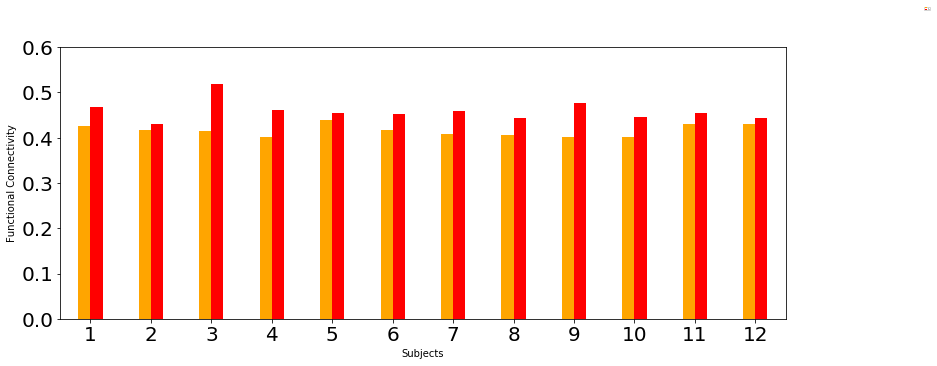

In [64]:
ind = np.arange(1,13) # the x locations for dmn, fpn
barwidth = 0.2 # width of individual bars
fig, ax = plt.subplots(figsize=(13,5))
fpn_bars = ax.bar(ind-(barwidth/2), fpn_df.iloc[:,0], barwidth, color = 'orange',align = 'center',label='fpn')
dmn_bars = ax.bar(ind+(barwidth/2), dmn_df.iloc[:,0], barwidth, color = 'red',align = 'center', label='dmn')
# dmn_bars
plt.xticks(subs_list_nos)
ax.set_ylim(0,0.6)
plt.yticks(fontsize=20)
ax.set_xlim(0.5,12.5)
ax.set_xlabel('Subjects')
ax.set_xticklabels(subs_list_nos,size='20')#, rotation=0,ha="centre")
ax.set_ylabel('Functional Connectivity')
ax.legend(bbox_to_anchor=(1.2,1.15), prop={'size':1})
plt.show()

In [46]:
round(((dmn_df.iloc[:,0] - fpn_df.iloc[:,0])*100),2)

0      4.32
1      1.42
2     10.20
3      6.08
4      1.54
5      3.40
6      5.14
7      3.58
8      7.50
9      4.33
10     2.32
11     1.32
Name: Average Max Value, dtype: float64

In [44]:
print(round(np.mean(dmn_df.iloc[:,0]),2), round(np.mean(dmn_df.iloc[:,1]),2), round(np.mean(dmn_df.iloc[:,2]),2))

0.46 0.54 0.31


In [45]:
print(round(np.mean(fpn_df.iloc[:,0]),2), round(np.mean(fpn_df.iloc[:,1]),2), round(np.mean(fpn_df.iloc[:,2]),2))

0.42 0.55 0.28


### E-field sizes

In [61]:
sub_e_field_patch_sizes_dlpfc = [415, 589, 786, 455, 433, 1037, 666, 781, 543, 936, 549, 857]
sub_e_field_patch_sizes_ofc = [136, 265, 106, 128, 138, 211, 156, 156, 151, 124, 300, 184]

In [119]:
np.mean(sub_e_field_patch_sizes_dlpfc)

670.5833333333334

In [120]:
np.mean(sub_e_field_patch_sizes_ofc)

171.25

In [121]:
np.std(sub_e_field_patch_sizes_dlpfc)

198.10622501296845

In [122]:
np.std(sub_e_field_patch_sizes_ofc)

56.78339692785794

In [63]:
width = 0.35

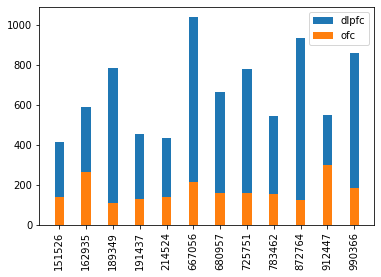

In [69]:
fig, ax = plt.subplots()

ax.bar(sub_list, sub_e_field_patch_sizes_dlpfc,width,label='dlpfc')
ax.bar(sub_list, sub_e_field_patch_sizes_ofc,width,label='ofc')
plt.xticks(rotation=90)
ax.legend()
plt.show()

In [87]:
blah = np.arange(1,13)
blah

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

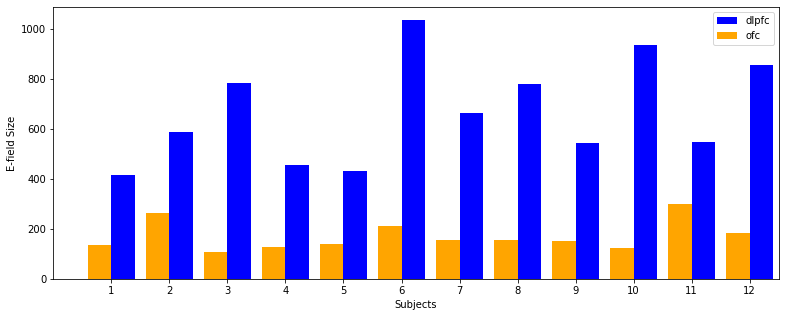

In [105]:
ind = np.arange(1,13) # the x locations for dmn, fpn
barwidth = 0.4 # width of individual bars
fig, ax = plt.subplots(figsize=(13,5))
dlpfc_bar = ax.bar(ind+(barwidth/2), sub_e_field_patch_sizes_dlpfc, barwidth, color = 'blue',align = 'center',label='dlpfc')
ofs_bars = ax.bar(ind-(barwidth/2), sub_e_field_patch_sizes_ofc, barwidth, color = 'orange',align = 'center', label='ofc')
plt.xticks(blah)
ax.set_xlim(0,12.5)
ax.set_xlabel('Subjects')
ax.set_ylabel('E-field Size')
ax.legend()
plt.show()

### --------------------------------------------------------------------------------------------------------------------------------------------------------------

### Graveyard

In [46]:
i

11

In [47]:
dconn_fstr = simnibs_hcp_dir + '/fmri_dconns/%s_rfMRI_REST1_LR_Atlas_MSMAll_hp2000_clean.dconn.nii'  
dconn_file = dconn_fstr %sub_list[i]
# Read DConn file in ...
img_dconn = nib.load(dconn_file)
dconn_dat = img_dconn.get_data()
dconn_hdr = img_dconn.header
dconn_ax0 = dconn_hdr.get_axis(0)
dconn_ax1 = dconn_hdr.get_axis(1)

In [ ]:
dconn_dat*10

```
Random notes:

this is one:

ls -l . | egrep -c '^-'
Note:

ls -1 | wc -l
Which means: ls: list files in dir

-1: (that's a ONE) only one entry per line. Change it to -1a if you want hidden files too

|: pipe output onto...

wc: "wordcount"

-l: count lines.

'''